This notebook is part of an exploratory analysis of machine learning used to decompose hyperspectral datasets of hybrid perovskite nanoscale materials.

Two machine learning models are mainly used in this project: Nonnegative Matrix Factorization (NMF) and Variational Autoencoders (VAEs). This notebook primarily focuses on using various unsupervised VAE models.

**Notebook Three: Unsupervised VAE**

# Imports, Functions, and Classes

## Imports

In [1]:
from ML_HSI_Analysis_0_Preprocessing_Loader import *

import torch; torch.manual_seed(0)
from torchvision.utils import make_grid
import pyroved as pv
import pyro.distributions as dist
import pyro
from pyroved.models.base import baseVAE
from pyroved.nets import fcDecoderNet, fcEncoderNet, sDecoderNet
from pyroved.utils import (generate_grid, get_sampler, set_deterministic_mode, 
                           to_onehot, transform_coordinates)

SEM images: f1_img1, f2_img1
CL images: f1_img2, f2_img2
Denoised data: f1_sb_median, f2_sb_median
2D denoised data: f1_denoised_2d, f2_denoised_2d
Example points: f1_x_points, f1_y_points, f2_x_points, f2_y_points
Wavelengths and dimensions: f1_wav, f2_wav, f1_xpix, f1_ypix, f1_zpix, f2_xpix, f2_ypix, f2_zpix


# Variational Autoencoder

An autoencoder is an unsupervised neural network model that learns two functions: an encoding function (transforms input into latent space representation with lower dimensionality) and a decoding function (recreates input data from latent representation). The autoencoder attempts to optimize the representation of unbalanced/non-linear data (as opposed to PCA or NMF, which are linear). It is more deterministic in its approach than a VAE.

Hyperparameters: Code size, number of layers, number of nodes per layer, and the loss function

Architecture: Input, encoder, latent space, decoder, and output

A variational autoencoder is a generative, semi-supervised autoencoder with the addition of regularized training (which prevents overfitting). This crucial additional step allows for each point in the latent space to yield meaningful data, allowing for generative processes. These are more probabilistic in nature and enforce a (generally Gaussian) distribution in the sampling process. The end result is a latent space that is optimized for clustering together similar data points while giving a continuous distribution across the entire latent space. This is achieved through minimizing the KL divergence (causing the mean to approach 0 and the standard deviation to approach 1).

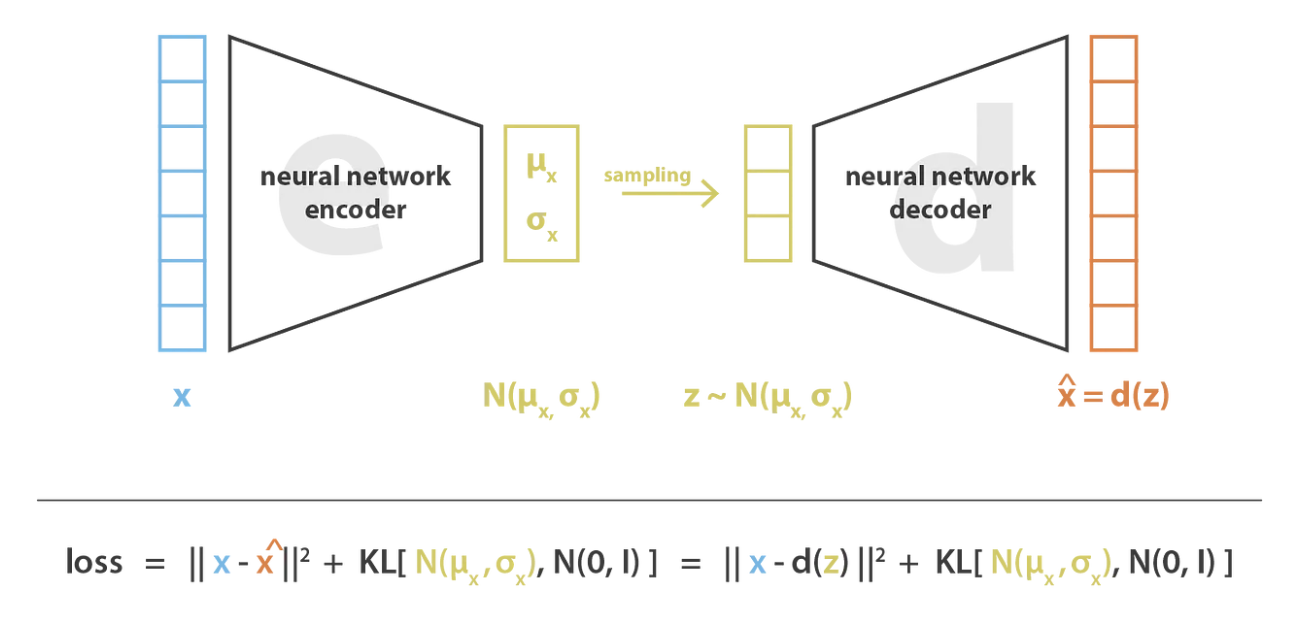

Loss function: reconstruction term (Gradient descent) (makes encoding and decoding efficient) + regularization term (Kullback-Leibler Divergence) (creates regular latent space)

VAEs use a "reparameterization trick" to allow for backpropagation, which is impossible through a stochastic node. The process of sampling from a distribution that is parameterized by the model is not differentiable, and this is a problem for gradient-based approaches. There must be a method of making the predictions separate from the stochastic sampling element.

It accomplishes this by treating random sampling as a noise term which is now independent and not parameterized by the model. A Gaussian can be scaled by a sample from the noise distribution multiplied by the standard deviation added to the mean. This allows for further differentiation through the model.

We are primarily interested in the latent space representation of the data as this reveals to us the correlations in the data that the model detects. However many latent dimensions we specify in the training will be the number of principal components we analyze and their correlations to one another.

## Plot Code

This builds a plot of the latent space dimensions with two or three latent dimensions and plots points corresponding to single pixels in the x and y axes of the original dataset. The point is to show a relationship between different spectral features detected by the autoencoder.

Below this plot are image components of the latent representation of the data.

In [28]:
def vae_plot(suptitle, z_mean, xpix, ypix, scalebar_size, save=False):
    
    rows = 2
    columns = len(z_mean[0])
    
    cmap = mpl.colormaps['viridis']
    fig = plt.figure(figsize=(4,4))
    fig.suptitle(suptitle, fontsize=10)
    if columns == 3:
        gs = GridSpec(rows, columns, top=0.3)
    else:
        gs = GridSpec(rows, columns)
    #gs_top = GridSpec(rows, columns, top=0.99)
    #gs_base = GridSpec(rows, columns, wspace=0.3, hspace=0.03, top=0.8, bottom=0.3)
    #gs_top.tight_layout(fig)
    #gs_base.tight_layout(fig)
    fig.patch.set_facecolor('white')
    
    for i in range(rows):
        column_count = 0
        for j in range(columns):
            if i == 0:
                if columns == 2: # 2D Latent space
                    ax = fig.add_subplot(gs[0,column_count])
                    ax.scatter(z_mean[:,0], z_mean[:,1], c=z_mean[:,column_count], cmap=cmap,
                            ec='black', lw=0.1, alpha=0.6, s=2)
                    ax.set_xticks([0.25, 0.5, 0.75, 1])
                    ax.set_yticks([0.25, 0.5, 0.75, 1])
                    ax.set_xticklabels([0.25, 0.5, 0.75, 1], fontsize=4)
                    ax.set_yticklabels([0.25, 0.5, 0.75, 1], fontsize=4)
                if columns == 3: # 3D Latent space
                    ax = fig.add_subplot(gs[0,column_count], projection='3d')
                    ax.scatter(z_mean[:,0], z_mean[:,1], z_mean[:,2], 
                            c=z_mean[:,column_count], cmap=cmap,
                            ec='black', lw=0.05, alpha=0.5, s=2)
                    ax.set_xticks([0.25, 0.5, 0.75, 1])
                    ax.set_yticks([0.25, 0.5, 0.75, 1])
                    ax.set_zticks([0.25, 0.5, 0.75, 1])
                    ax.set_xticklabels([])
                    ax.set_yticklabels([])
                    ax.set_zticklabels([])
                    ax.set_xlabel("X", size=10, labelpad=-15)
                    ax.set_ylabel("Y", size=10, labelpad=-15)
                    ax.set_zlabel("Z", size=10, labelpad=-15)
                    #ax.set_zticklabels([0.25, 0.5, 0.75, 1], fontsize=5)
                    if j == 0:
                        ax.view_init(30, -90) 
                    elif j == 1:
                        ax.view_init(30, -30)
                    elif j == 2:
                        ax.view_init(30, 30)
                ax.tick_params(axis='both', which='minor', labelsize=10, direction='out', 
                               length=6, width=2)
                if column_count == 0:
                    ax.set_title('Latent Space', size=10)
            
            if i == 1:
                img = fig.add_subplot(gs[1,column_count])
                img.imshow(z_mean[:,column_count].reshape(ypix, xpix), cmap=cmap)
                img.set_xticks([])
                img.set_yticks([])
                
                if column_count == (columns-1):
                    scalebar = AnchoredSizeBar(img.transData, scalebar_size, " ", 
                            "lower right", pad=0.2, color='#F2F2F2', frameon=False,
                                               size_vertical=3, label_top=True)
                    img.add_artist(scalebar)

            column_count += 1
    
    if save:
        fig.savefig("VAE/" + suptitle + ".png")

In [23]:
# Spectra Plot (For determining latent dimensions)
def spectra_plot(title, img, array, xpix, ypix, wav, save=False):
    
    n = xpix*ypix # total number of spectra
    cmap = mpl.colormaps['viridis'](np.linspace(0,1,n)) # create colormap
    fig = plt.figure(figsize=(4,4))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot()
    ax.set_prop_cycle('color', list(cmap)) # colormaps each spectra from first to last in array
    ax.set_title(title, size=8)
    plt.xlim(short_wav, long_wav)
    #ax.set_xticks([500, 750])
    #ax.set_xticklabels([])
    #plt.yscale('log')
    
    for i in array:
        ax.plot(wav, img[:,i[0],i[1]], lw=0.1, alpha=0.5)
    
    if save:
        fig.savefig("VAE/" + title + ".png")

### Manifold

An attempt to create my own manifold. The manifold uses the continuous representation of the data's features in the latent space to generate its own spectra (to an infinitesimal degree). This is to help determine what features each axis corresponds to.

In [ ]:
def generate_latent_grid(d: int, **kwargs) -> torch.Tensor:
    """
    Generates a grid of latent space coordinates
    """
    if isinstance(d, int):
        d = [d, d]
    z_coord = kwargs.get("z_coord")
    if z_coord:
        z1, z2, z3, z4 = z_coord
        grid_x = torch.linspace(z2, z1, d[0])
        grid_y = torch.linspace(z3, z4, d[1])
    else:
        grid_x = dist.Normal(0, 1).icdf(torch.linspace(0.95, 0.05, d[0]))
        grid_y = dist.Normal(0, 1).icdf(torch.linspace(0.05, 0.95, d[1]))
    z = []
    for xi in grid_x:
        for yi in grid_y:
            z.append(tt([xi, yi]).float().unsqueeze(0))
    return torch.cat(z), (grid_x, grid_y)

def plot_img_grid(imgdata: torch.Tensor, d: int,
                  **kwargs: Union[str, int, List[float]]) -> None:
    """
    Plots a *d*-by-*d* square grid of 2D images
    """
    if imgdata.ndim < 3:
        raise AssertionError("Images must be passed as a 3D or 4D tensor")
    imgdata = imgdata[:, None] if imgdata.ndim == 3 else imgdata
    grid = make_grid(imgdata, nrow=d,
                     padding=kwargs.get("padding", 2),
                     pad_value=kwargs.get("pad_value", 0)).cpu()
    extent = kwargs.get("extent")
    # Put on cpu in case all tensors are created on gpu by default
    extent_ = [e.cpu() for e in extent]
    plt.figure(figsize=(8, 8))
    plt.imshow(grid[0].squeeze(), cmap=kwargs.get("cmap", "gnuplot"),
               origin=kwargs.get("origin", "upper"),
               extent=extent_)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18)
    plt.show()
    
def plot_spect_grid(spectra: torch.Tensor, d: int, **kwargs: List[float]):  # TODO: Add 'axes' and 'extent'
    """
    Plots a *d*-by-*d* square grid with 1D spectral plots
    """
    _, axes = plt.subplots(d, d, figsize=(8, 8),
                           subplot_kw={'xticks': [], 'yticks': []},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
    ylim = kwargs.get("ylim")
    spectra = spectra.cpu()
    for ax, y in zip(axes.flat, spectra):
        ax.plot(y.squeeze(), color=color[ax])
        if ylim:
            ax.set_ylim(*ylim)
    plt.show()

### Other

In [ ]:
"""
def vae_plot(z_mean, xpix, ypix, nmf_img_matrices):
    
    rows = len(z_mean[0])+1
    columns = 2
    
    cmap = mpl.colormaps['viridis_r']
    fig = plt.figure(figsize=(8,rows*4))
    gs = fig.add_gridspec(2, 1)
    gs_top = gs[0].subgridspec(1, 1, hspace=0.75)
    gs_base = gs[1].subgridspec(rows-1, columns, wspace=0.2, hspace=0.05)
    
    ax1 = fig.add_subplot(gs_top[0,:])
    ax1.scatter(z_mean[:,0], z_mean[:,1], c=z_mean[:,0], cmap=cmap, 
                ec='black', lw=0.5, alpha=.75, s=20)
    ax1.set_xlabel('$z_1$', size=20)
    ax1.set_ylabel('$z_2$', size=20)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.set_title('Latent Space', size=20)
    
    nmf_matrix = len(z_mean[0])-2
    row_count = 1
    
    for i in range(rows-1):

        ax2 = fig.add_subplot(gs_base[row_count-1,0])
        ax2.imshow(z_mean[:,row_count-2].reshape(ypix, xpix), cmap=cmap)
        ax2.set_xticks([])
        ax2.set_yticks([])
        if row_count == 1:
            ax2.set_title('VAE', size=20)

        ax3 = fig.add_subplot(gs_base[row_count-1,1])
        ax3.imshow(nmf_img_matrices[nmf_matrix][row_count-1].reshape(ypix, xpix), 
                   cmap='viridis')
        ax3.set_xticks([])
        ax3.set_yticks([])
        if row_count == 1:
            ax3.set_title('NMF', size=20)
            
        row_count += 1
    
"""

## Invariant VAE (2 latent dimensions)

Variational autoencoder that enforces rotational, translational, and scale invariances. The goal is to remove any effect these transformations will cause in the encoding process and to pick up on the similarities in the features.

### Grain 1

#### Code

First step: Transpose denoised array, reshape to 1D, normalize entire dataset, and reshape to 2D

Second step: Convert from Numpy array to PyTorch tensor, then find number of samples (spectra) and signal (number of points in image along x and y axes containing spectra)

(pv.utils.init_dataloader: Returns initialized PyTorch dataloader, which is used by pyroVED’s trainers. The inputs are torch Tensor objects containing training data and, optionally, labels.)

Third step: Create a dataloader object with unsqueezed training data. This is the entire hyperspectral array reshaped into 2 dimensions with another dimension of size one inserted into the array

(pyroved.trainers.SVItrainer: Stochastic variational inference (SVI) trainer for unsupervised and class-conditioned VED models consisting of one encoder and one decoder.)

Fourth step: An invariant VAE model with 2 latent dimensions is created along with an SVI trainer. Then, 50 epochs are run with every 10 epochs printing the training loss, showing the convergence to local minima.

Fifth step: pv.models.iVAE.encode returns the mean and standard deviation of the Z (latent) space, giving an array of image points (20008 for Figure 1), each containing an entire spectrum, plotted on an axis of specified latent dimensions (in this case, 2)

In [4]:
# Reshaping the 2D array to 1D. Imagine the 3D hyperspectral image, take the top left pixel's (from the perspective of the x-y plane)
# spectrum, add the spectrum of the pixel to the right to the end, and continue left to right, top to bottom, until the entire image is 1D.
f1_denoised_1d_transpose = f1_denoised_2d.transpose(1,0).reshape(f1_zpix*f1_ypix*f1_xpix)
# Normalize the entire 1D array, then reshape it to 2D, pixels by spectra, arranged left to right and top to bottom
f1_denoised_2d_norm = normalize(f1_denoised_1d_transpose).reshape(f1_xpix*f1_ypix, f1_zpix)
# Convert to Torch tensor object
f1_denoised_2d_norm_t = torch.from_numpy(np.array(f1_denoised_2d_norm).astype('float64')).float()
f1_n_samples = f1_denoised_2d_norm_t.size()[0] # number of spectral points
f1_l_signal = f1_denoised_2d_norm_t.size()[1] # number of spectra

f1_train_data = f1_denoised_2d_norm_t.clone()
f1_train_loader = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=64)

f1_in_dim = (f1_l_signal,)
# Gradually increase the weight of the KL Divergence term in the loss function with each epoch
f1_kl_scale = torch.linspace(start=.001, end=.01, steps=50)

In [5]:
f1_vae = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer = pv.trainers.SVItrainer(f1_vae)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer.step(f1_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer.print_statistics()
        
f1_vae_z_mean, f1_vae_z_sd = f1_vae.encode(f1_train_data)

f1_vae_z_mean = normalize(f1_vae_z_mean)
f1_vae_z_sd = normalize(f1_vae_z_sd)

Epoch: 1 Training loss: 157.6064
Epoch: 11 Training loss: 145.6802
Epoch: 21 Training loss: 145.6788
Epoch: 31 Training loss: 145.6842
Epoch: 41 Training loss: 145.6906


#### Plot

##### Determining latent dimensions

Determining what each latent dimension corresponds to in the material is a nontrivial process. Here I have plotted the spectra contained in the pixels lying at the minimum and maximum values in each dimension (x and y axes) in order to determine more about the latent dimensions.

In [6]:
# X-axis
# Convert to np array and reshape to 2d
f1_vae_z_mean_x = f1_vae_z_mean[:,0].detach().cpu().numpy()
f1_vae_z_mean_x = f1_vae_z_mean_x.reshape(f1_ypix, f1_xpix)
print("X Min: ", (f1_vae_z_mean_x==np.min(f1_vae_z_mean_x)).nonzero())
print("X Max: ", (f1_vae_z_mean_x==np.max(f1_vae_z_mean_x)).nonzero())

f1_vae_z_mean_x_sort = np.dstack(
    np.unravel_index(np.argsort(f1_vae_z_mean_x.ravel()), (f1_ypix, f1_xpix)))
f1_vae_z_mean_x_sort = np.squeeze(f1_vae_z_mean_x_sort)

spectra_plot("Vanilla VAE Grain 1 Spectra from X-axis of Latent Space", f1_img2, f1_vae_z_mean_x_sort, 
             f1_xpix, f1_ypix, f1_wav, True)

X Min:  (array([62]), array([23]))
X Max:  (array([11]), array([57]))


In [8]:
# Y-axis
f1_vae_z_mean_y = f1_vae_z_mean[:,1].detach().cpu().numpy()
f1_vae_z_mean_y = f1_vae_z_mean_y.reshape(f1_ypix, f1_xpix)
print("Y Min: ", (f1_vae_z_mean_y==np.min(f1_vae_z_mean_y)).nonzero())
print("Y Max: ", (f1_vae_z_mean_y==np.max(f1_vae_z_mean_y)).nonzero())

f1_vae_z_mean_y_sort = np.dstack(
    np.unravel_index(np.argsort(f1_vae_z_mean_y.ravel()), (f1_ypix, f1_xpix)))
f1_vae_z_mean_y_sort = np.squeeze(f1_vae_z_mean_y_sort)

spectra_plot("Vanilla VAE Grain 1 Spectra from Y-axis of Latent Space", f1_img2, f1_vae_z_mean_y_sort, 
             f1_xpix, f1_ypix, f1_wav, True)

Y Min:  (array([36]), array([18]))
Y Max:  (array([41]), array([1]))


Conclusion: The x-axis (Z_1) is the relative amplitude of the 750nm (main perovskite) peak and the y-axis (Z_2) is the presence of the 400nm peak.

##### The plots

Each pixel in the original data is plotted in terms of x and y (taken from the latent space) with each dimension corresponding to a distinct feature. The two separate color mappings show the intensity of each feature in the pixels' spatial locations in the image.

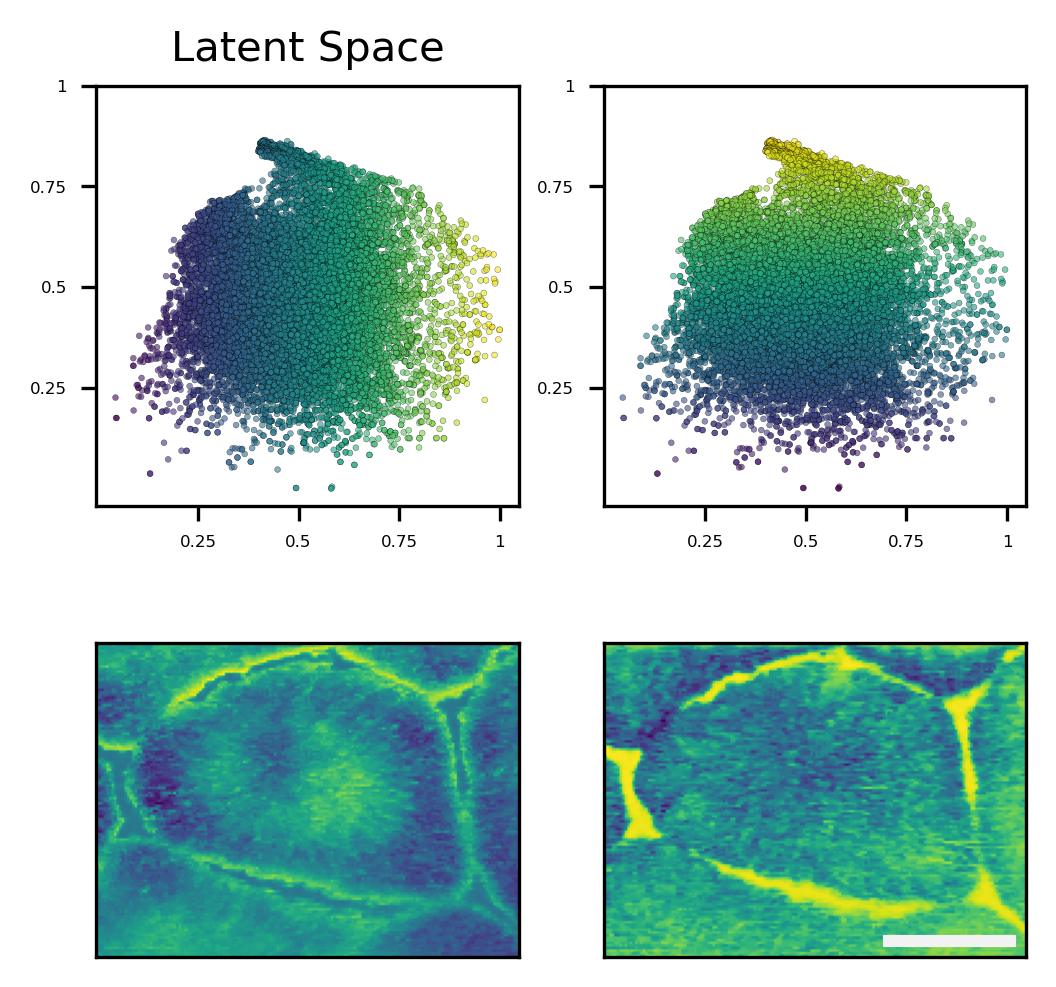

In [29]:
vae_plot("Vanilla VAE Grain 1", f1_vae_z_mean, f1_xpix, f1_ypix, 50)

This 2D manifold is generated from the decoder portion of the VAE and represents a continuous distribution of data in the latent space. Each dimension corresponds to one of two features.

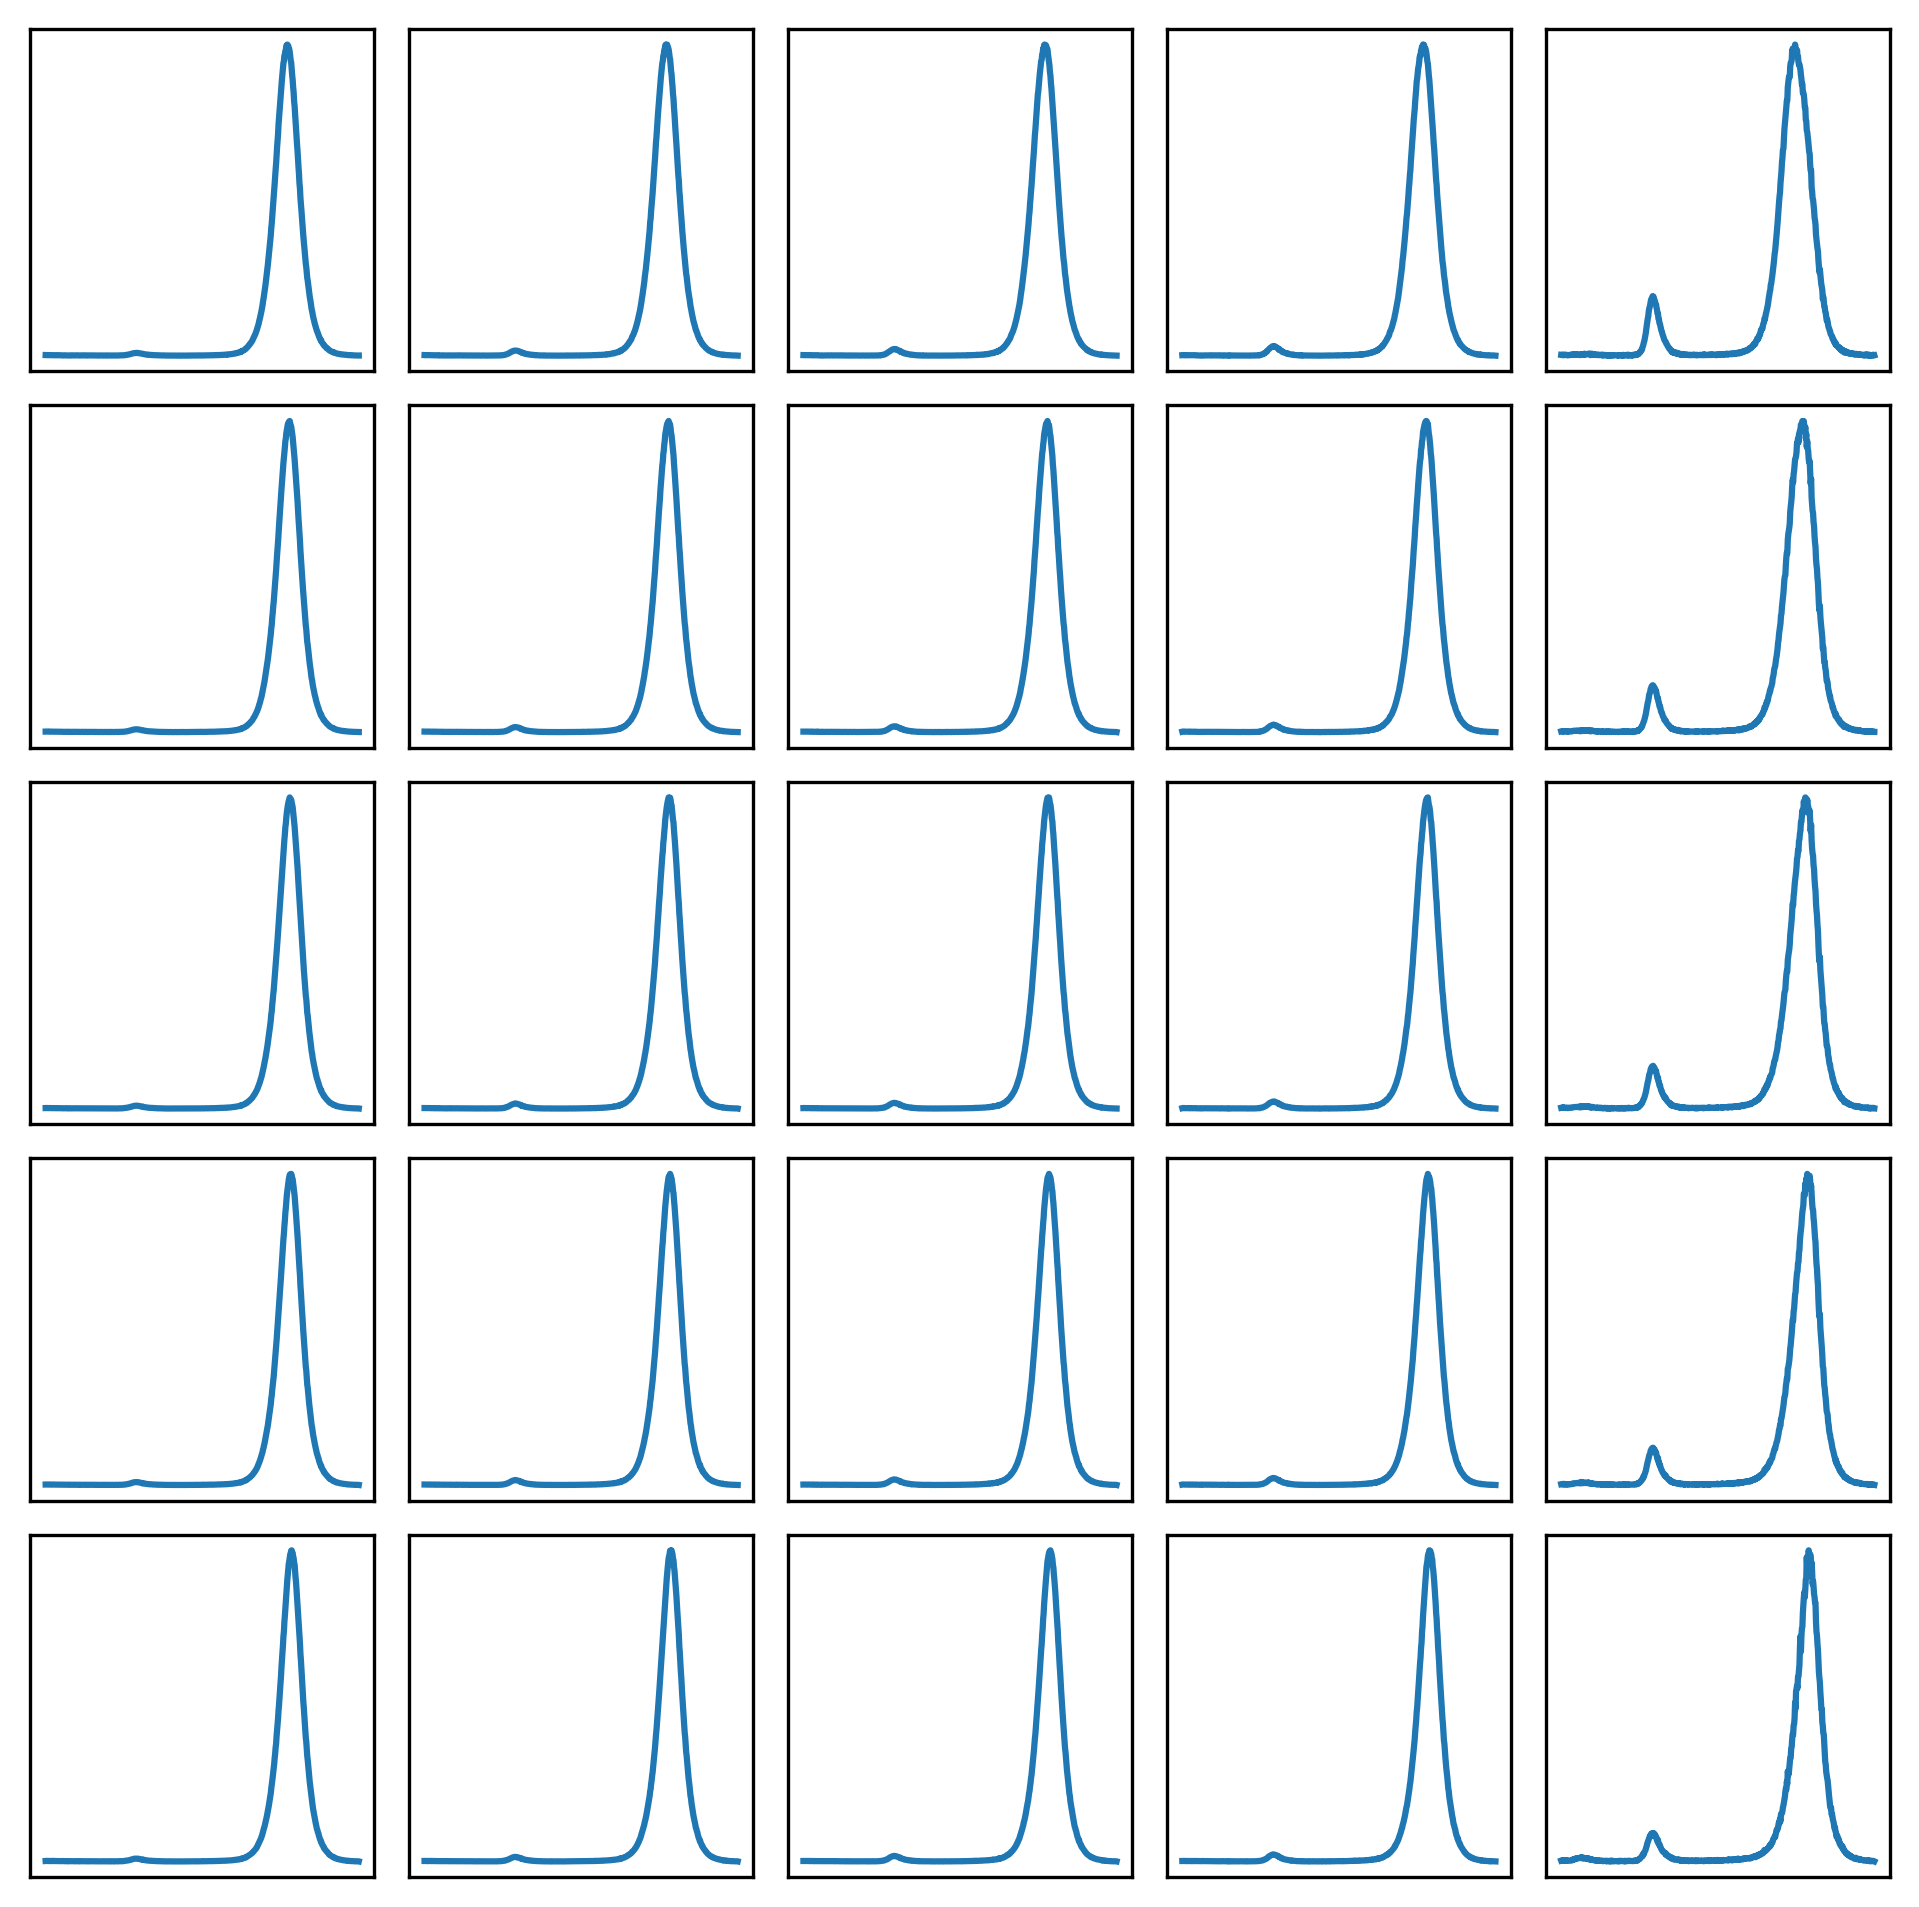

In [12]:
f1_vae.manifold2d(d=5, extent=[-5,5,-5,5]);

##### Standard deviation plot

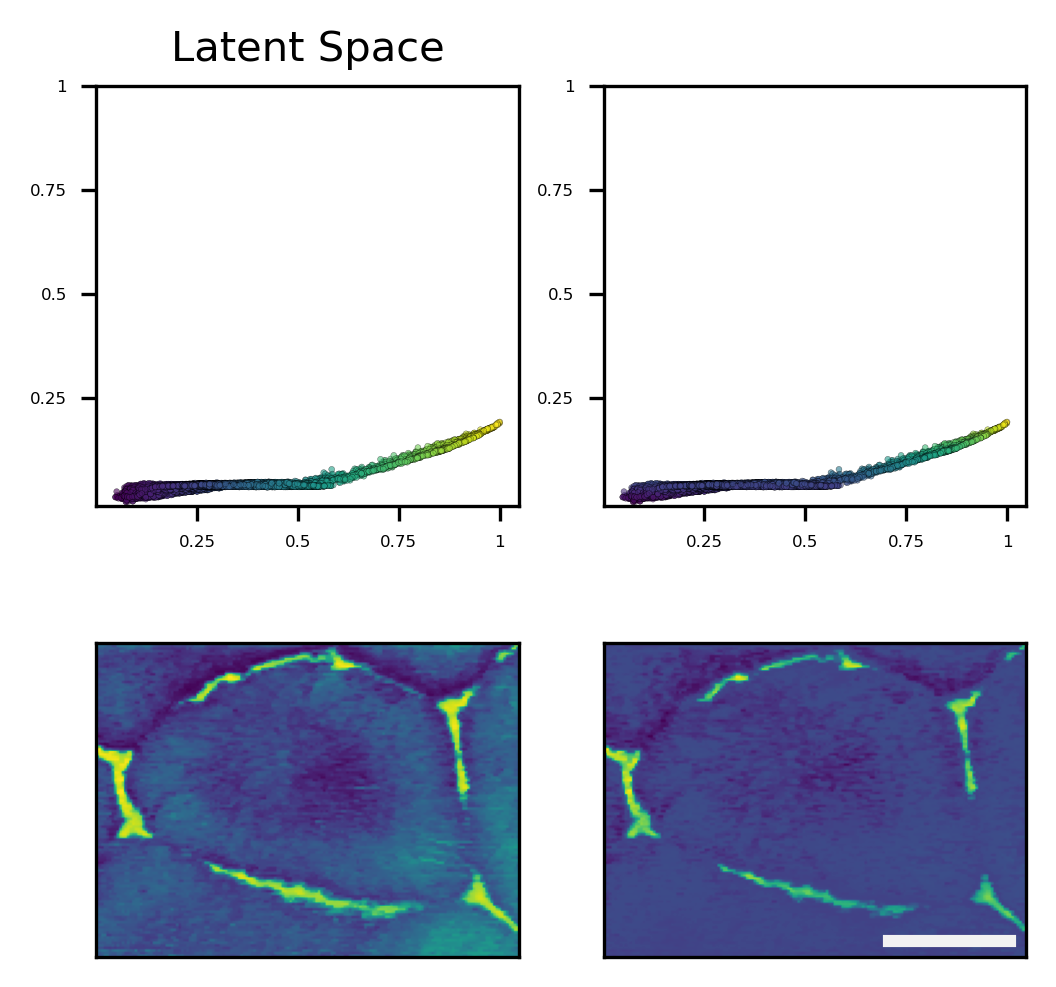

In [30]:
vae_plot("Vanilla VAE Grain 1 Standard Deviation Plot", f1_vae_z_sd, f1_xpix, f1_ypix, 50)

##### Bernoulli Sampling

Bernoulli (discrete) sampling as opposed to Gaussian (weighted, continuous) sampling appears to treat spatial regions differently from one another resulting in a compression of the data in the higher y values. It does not provide an immediately useful representation of the data.

In [14]:
f1_vae_b = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="bernoulli")
f1_vae_trainer_b = pv.trainers.SVItrainer(f1_vae_b)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_b.step(f1_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_b.print_statistics()

f1_vae_z_mean_b, f1_vae_z_sd_b = f1_vae_b.encode(f1_denoised_2d_norm_t)
f1_vae_z_mean_b = normalize(f1_vae_z_mean_b)
f1_vae_z_sd_b = normalize(f1_vae_z_sd_b)

Epoch: 1 Training loss: 72.8436
Epoch: 11 Training loss: 52.2194
Epoch: 21 Training loss: 52.2068
Epoch: 31 Training loss: 52.2085
Epoch: 41 Training loss: 52.2146


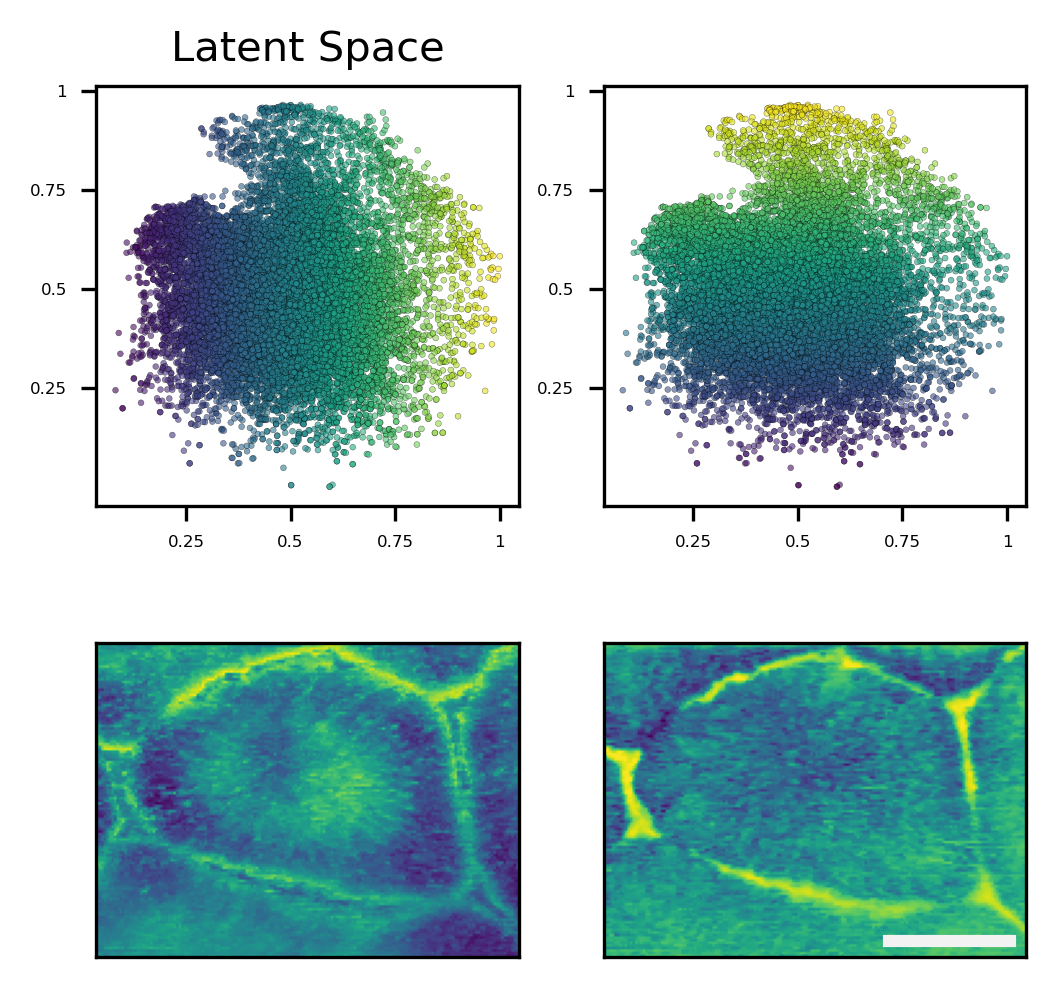

In [31]:
vae_plot("Vanilla VAE Grain 1 Bernoulli Sampling Plot", f1_vae_z_mean_b, f1_xpix, f1_ypix, 50)

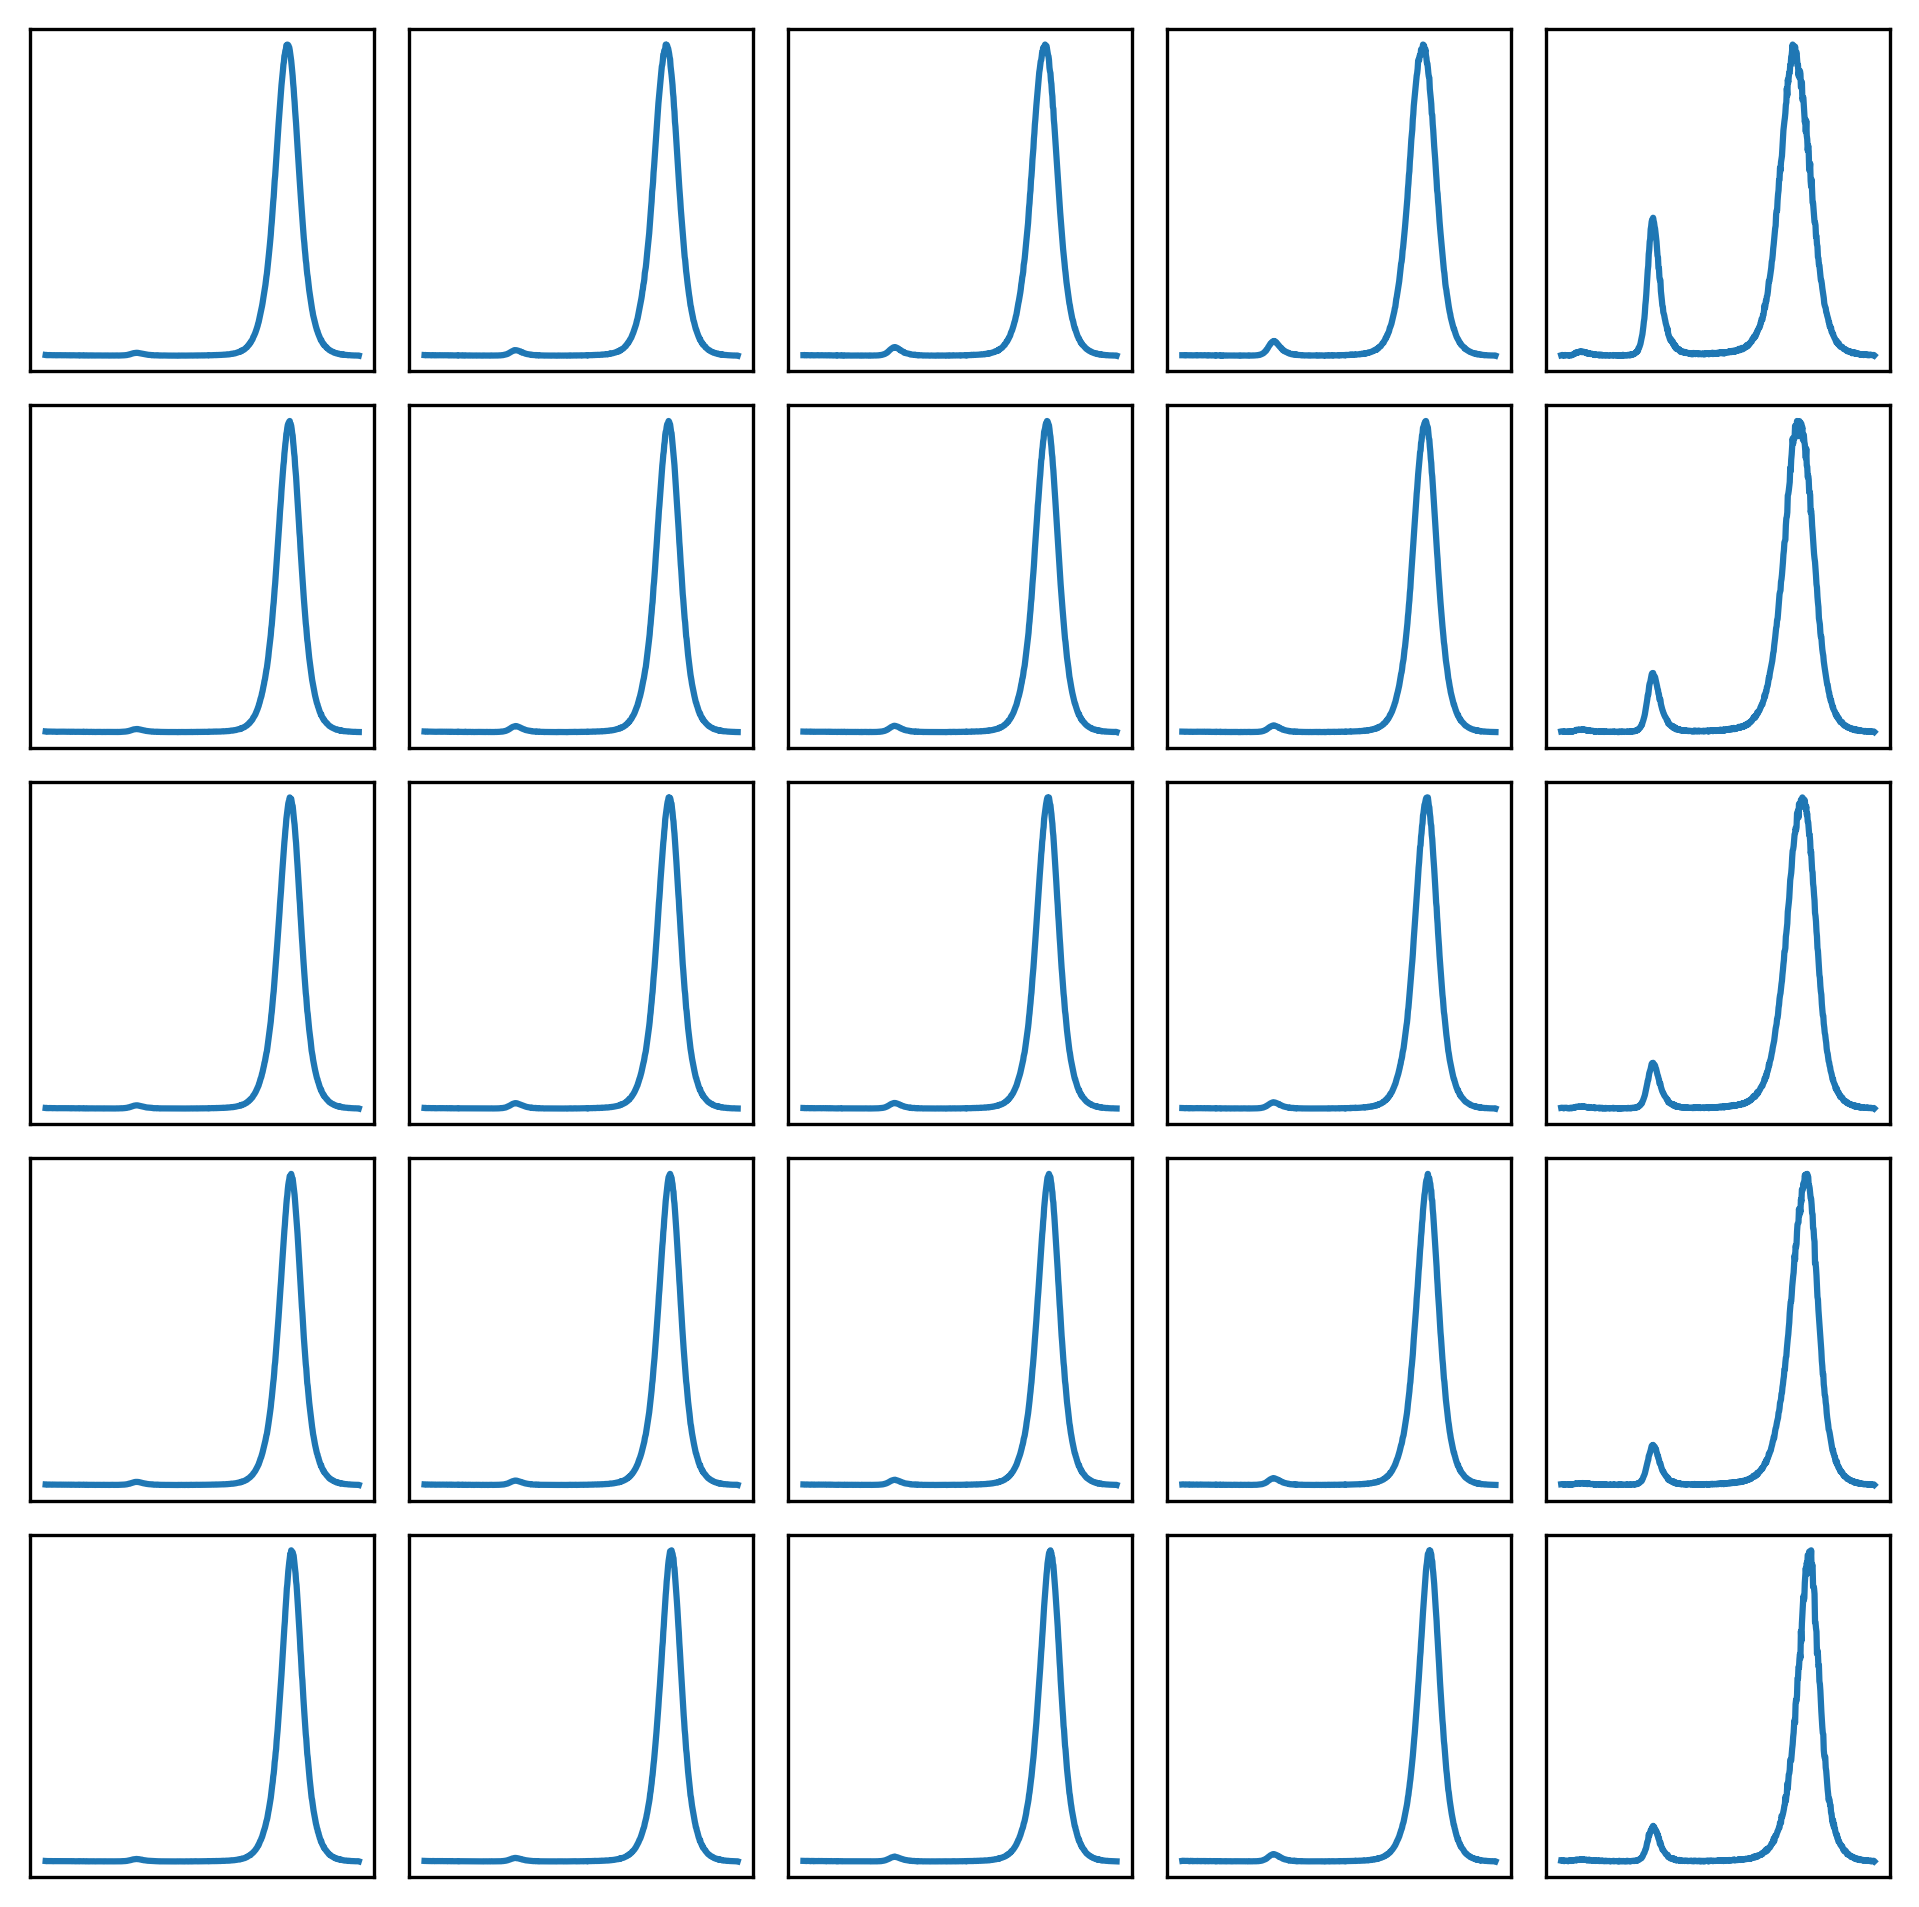

In [16]:
f1_vae_b.manifold2d(d=5, extent=[-5,5,-5,5]);

##### Extra

In [ ]:
#fig, ax = plt.subplots()
#ax.plot(f1_vae_g.decode(torch.tensor([-2., 0.]))[0], c=color[0], lw=4)
#ax.plot(f1_vae_g.decode(torch.tensor([2., 0.]))[0], c=color[-1], lw=4)
#plt.show()

In [ ]:
#fig, ax = plt.subplots()
#ax.plot(f1_vae.decode(torch.tensor([0., 2.]))[0], c=color[0], lw=4)
#ax.plot(f1_vae.decode(torch.tensor([0., -2.]))[0], c=color[-1], lw=4)
#plt.show()

### Grain 2

#### Code

In [17]:
f2_denoised_1d_transpose = f2_denoised_2d.transpose(1,0).reshape(f2_zpix*f2_ypix*f2_xpix)
f2_denoised_2d_norm = normalize(f2_denoised_1d_transpose).reshape(f2_ypix*f2_xpix, f2_zpix)
    
f2_denoised_2d_norm_t = torch.from_numpy(np.array(f2_denoised_2d_norm).astype('float64')).float()

f2_n_samples = f2_denoised_2d_norm_t.size()[0] # number of spectra
f2_l_signal = f2_denoised_2d_norm_t.size()[1] # number of spectral points

f2_train_data = f2_denoised_2d_norm_t.clone()
f2_train_loader = pv.utils.init_dataloader(f2_train_data.unsqueeze(1), batch_size=64)

f2_in_dim = (f2_l_signal,)
f2_kl_scale = torch.linspace(.001, .01, 50)

In [18]:
f2_vae = pv.models.iVAE(f2_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f2_vae_trainer = pv.trainers.SVItrainer(f2_vae)

for e in range(50):
    sc = f2_kl_scale[e] if e < len(f2_kl_scale) else f2_kl_scale[-1]
    f2_vae_trainer.step(f2_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f2_vae_trainer.print_statistics()
        
f2_vae_z_mean, f2_vae_z_sd = f2_vae.encode(f2_denoised_2d_norm_t)

f2_vae_z_mean = normalize(f2_vae_z_mean)
f2_vae_z_sd = normalize(f2_vae_z_sd)

Epoch: 1 Training loss: 179.1582
Epoch: 11 Training loss: 145.7374
Epoch: 21 Training loss: 145.7132
Epoch: 31 Training loss: 145.7104
Epoch: 41 Training loss: 145.6995


#### Plot

##### Determining latent dimensions

X Min:  (array([0]), array([45]))
X Max:  (array([31]), array([19]))


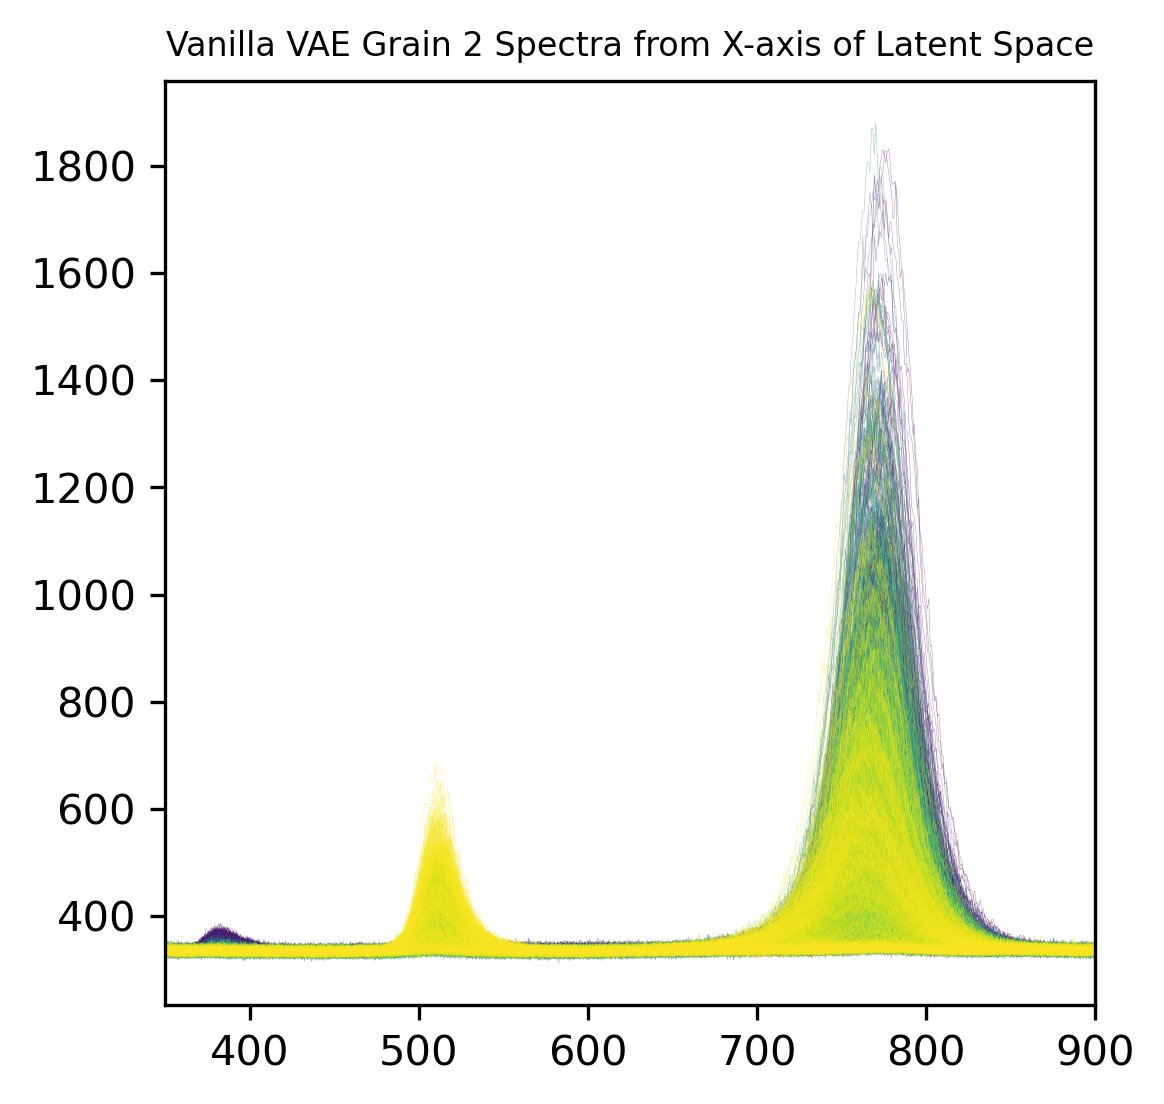

In [45]:
# X-axis
# Convert to np array and reshape to 2d
f2_vae_z_mean_x = f2_vae_z_mean[:,0].detach().cpu().numpy()
f2_vae_z_mean_x = f2_vae_z_mean_x.reshape(f2_ypix, f2_xpix)
print("X Min: ", (f2_vae_z_mean_x==np.min(f2_vae_z_mean_x)).nonzero())
print("X Max: ", (f2_vae_z_mean_x==np.max(f2_vae_z_mean_x)).nonzero())
f2_vae_z_mean_x_sort = np.dstack(
    np.unravel_index(np.argsort(f2_vae_z_mean_x.ravel()), (f2_ypix, f2_xpix)))
f2_vae_z_mean_x_sort = np.squeeze(f2_vae_z_mean_x_sort)

spectra_plot("Vanilla VAE Grain 2 Spectra from X-axis of Latent Space", f2_img2, 
             f2_vae_z_mean_x_sort, f2_xpix, f2_ypix, f2_wav)

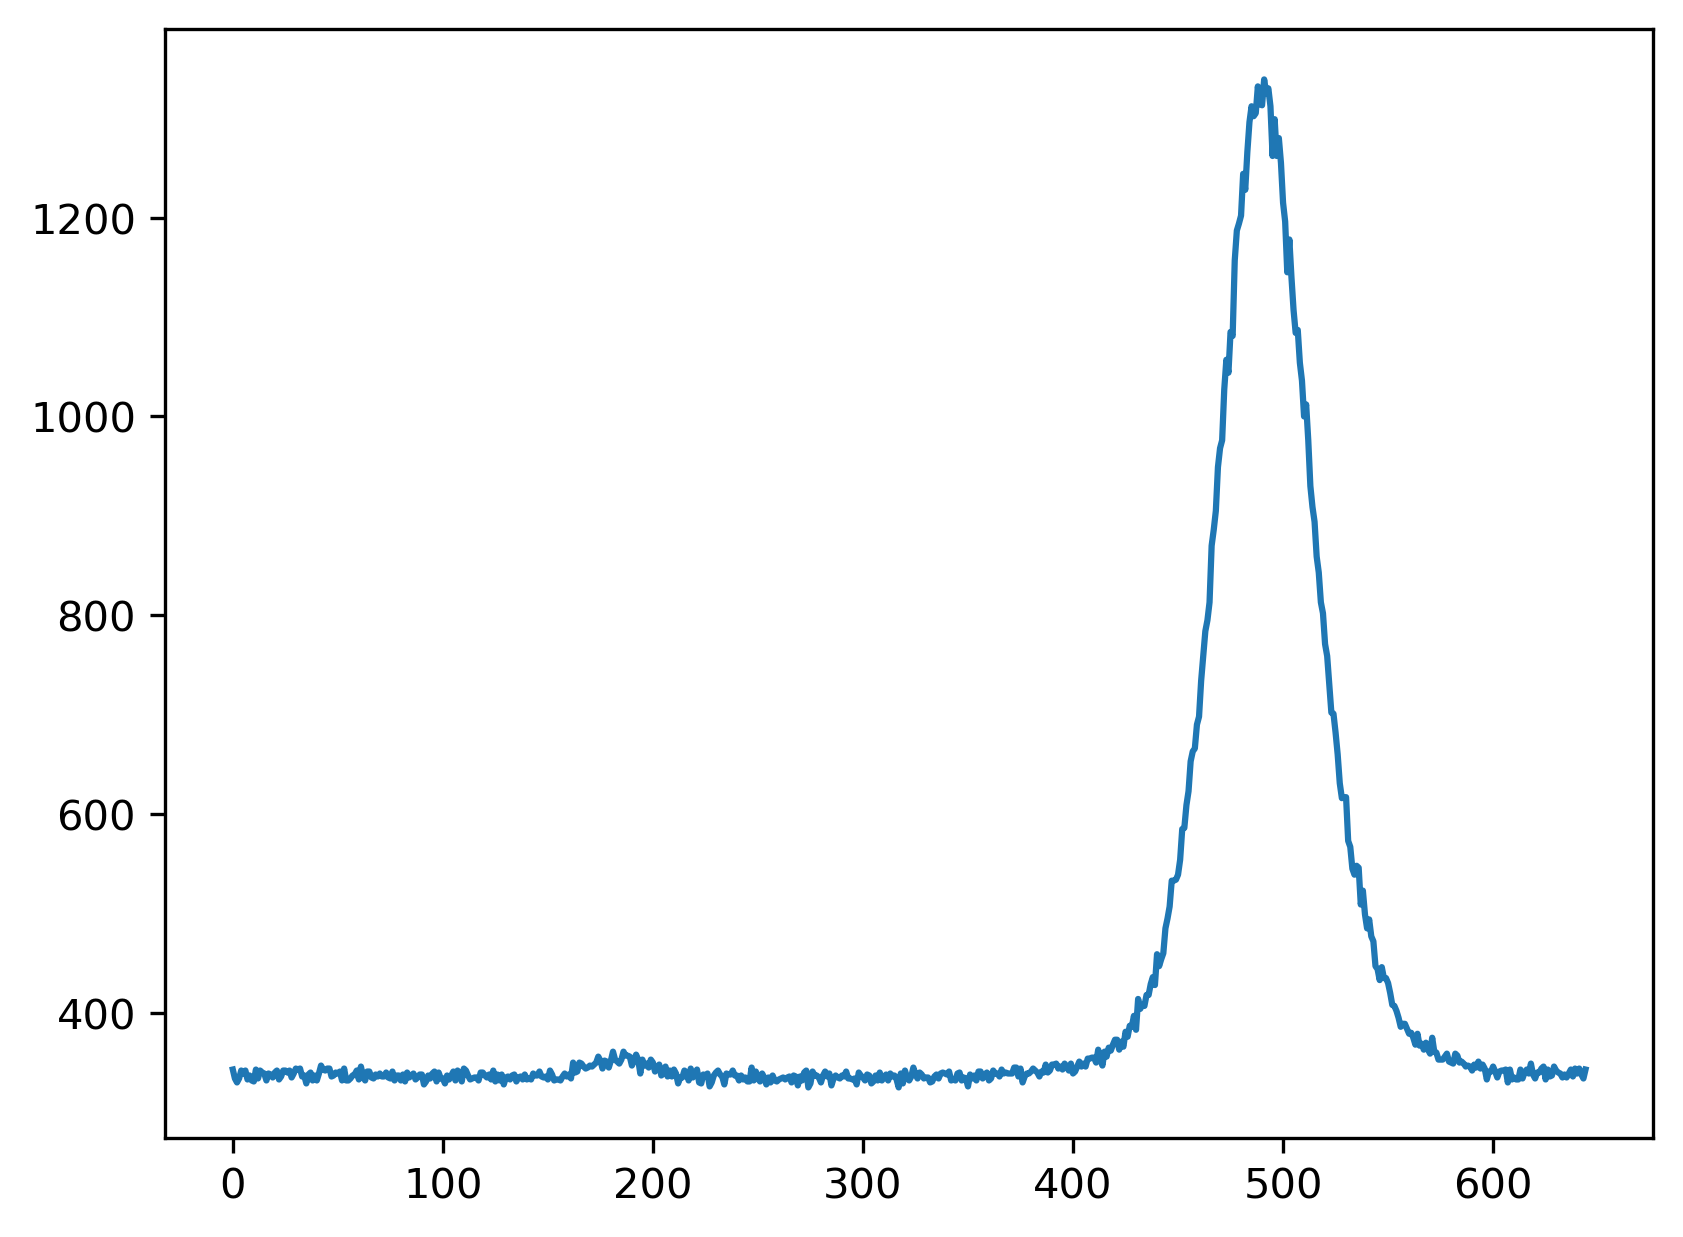

In [35]:
# X Min
plt.plot(f2_img2[:,16,57])

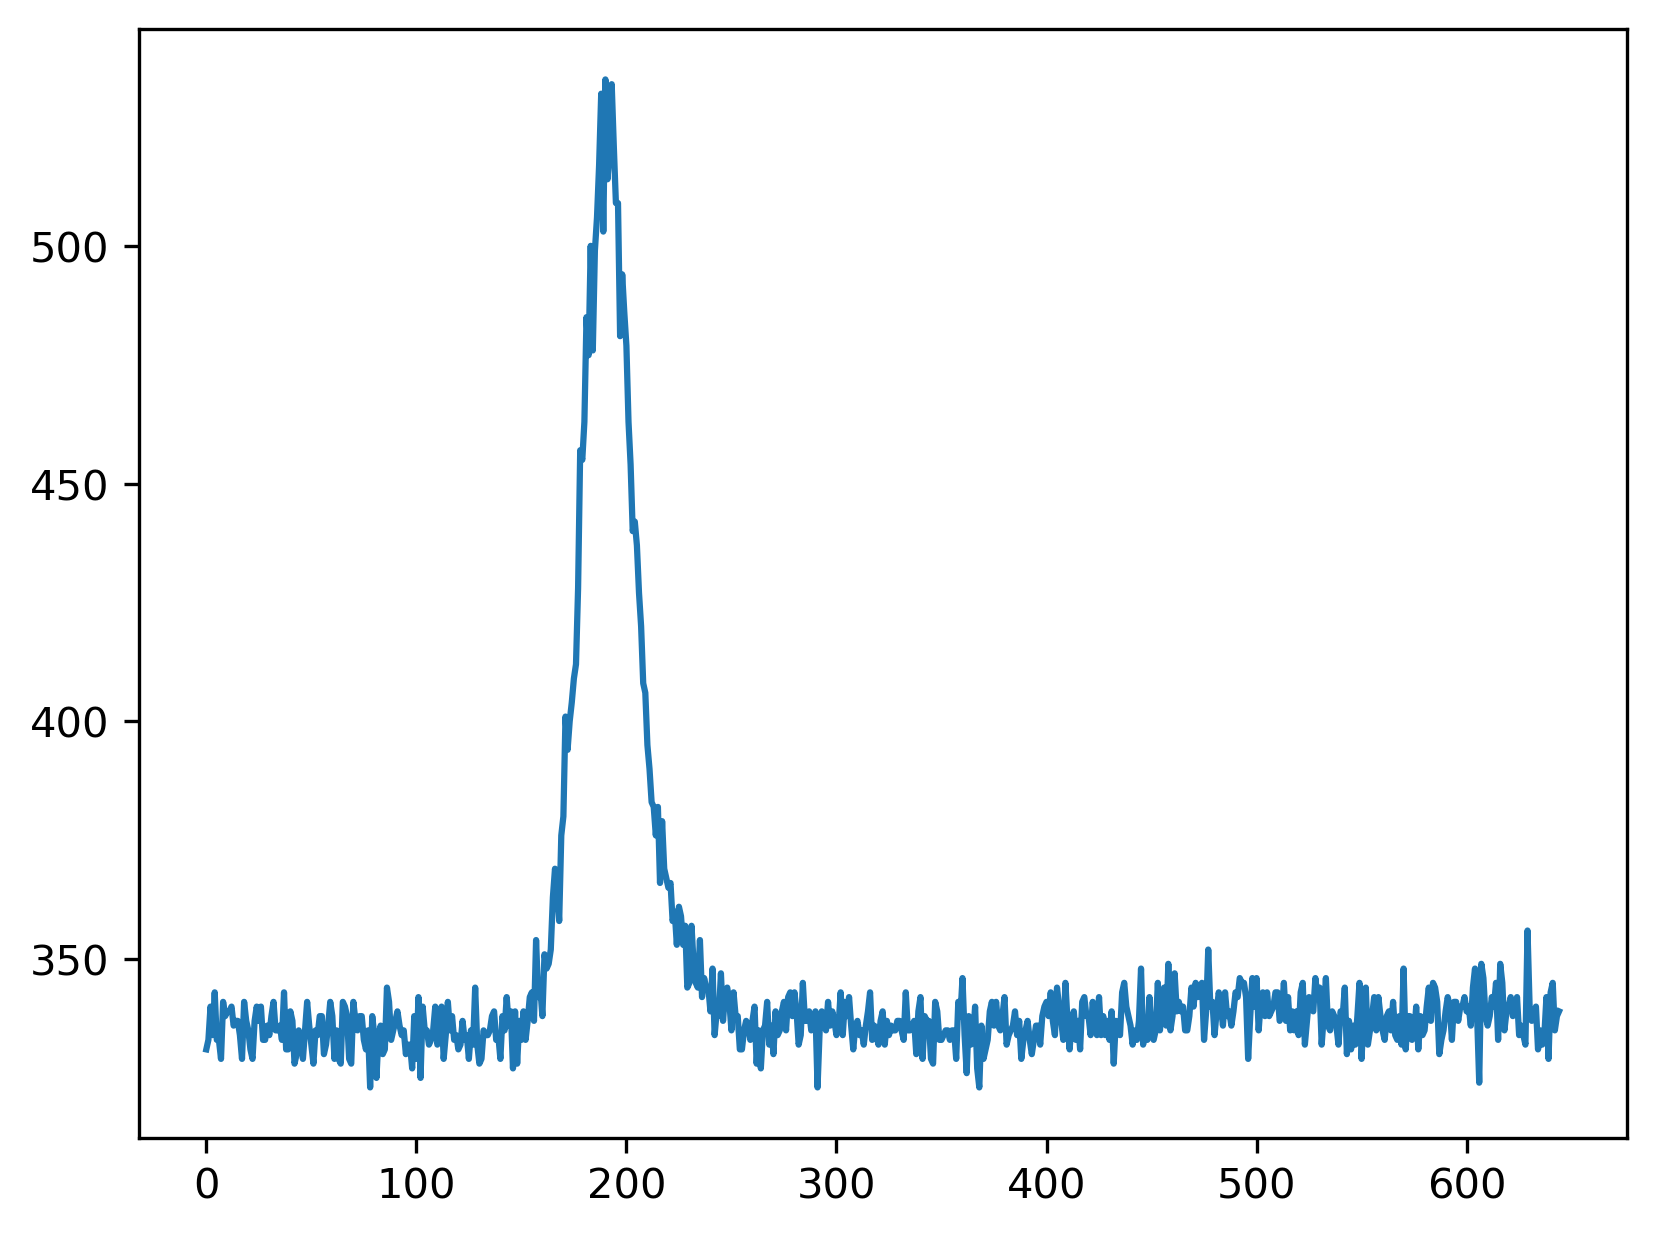

In [36]:
# X Max
plt.plot(f2_img2[:,42,42])

Y Min:  (array([16]), array([56]))
Y Max:  (array([52]), array([65]))


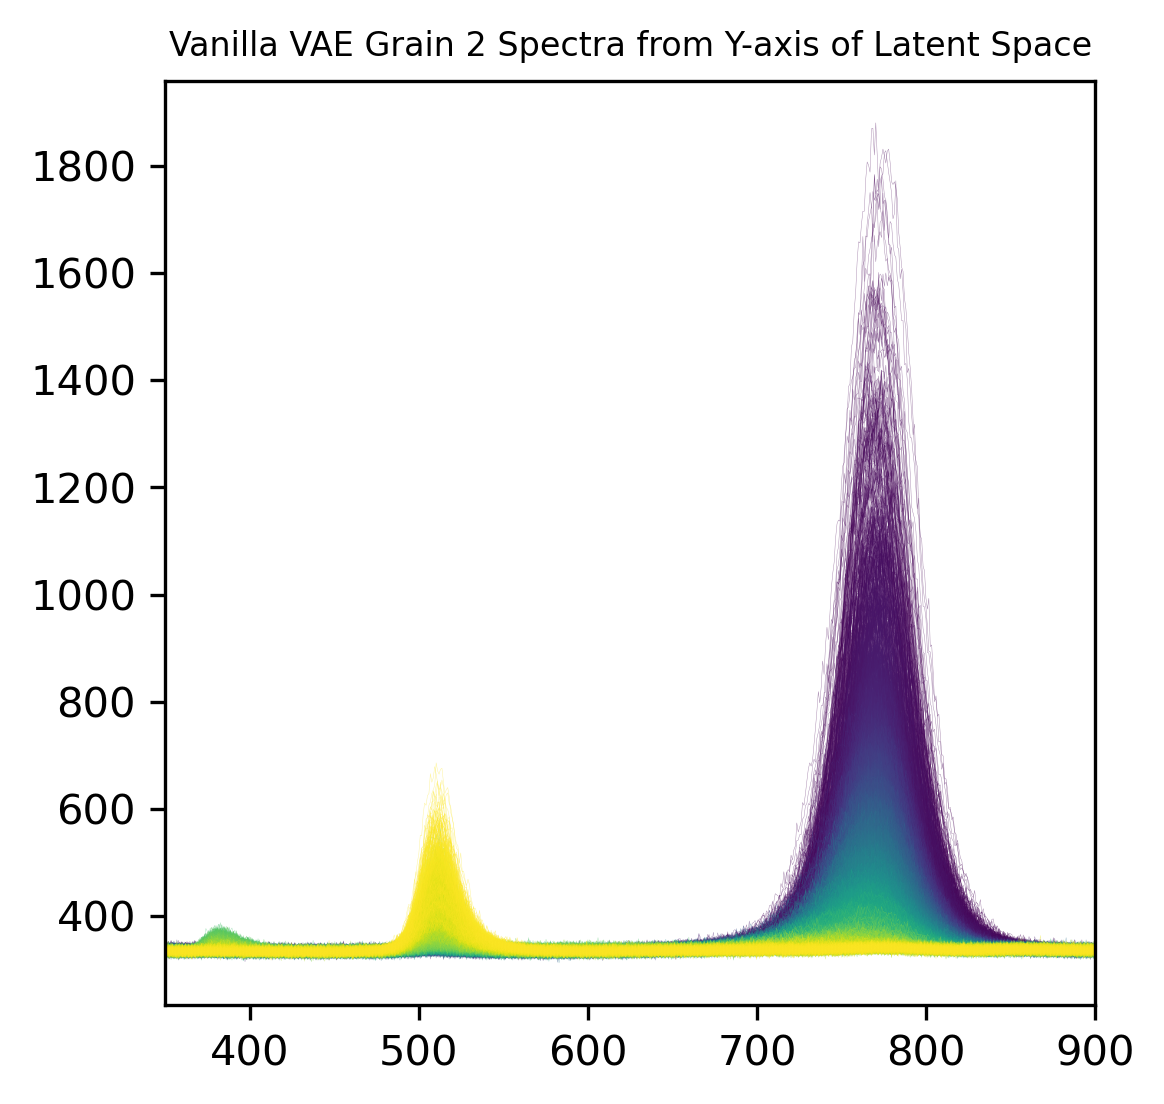

In [38]:
# Y-axis
f2_vae_z_mean_y = f2_vae_z_mean[:,1].detach().cpu().numpy()
f2_vae_z_mean_y = f2_vae_z_mean_y.reshape(f2_ypix, f2_xpix)
print("Y Min: ", (f2_vae_z_mean_y==np.min(f2_vae_z_mean_y)).nonzero())
print("Y Max: ", (f2_vae_z_mean_y==np.max(f2_vae_z_mean_y)).nonzero())
f2_vae_z_mean_y_sort = np.dstack(
    np.unravel_index(np.argsort(f2_vae_z_mean_y.ravel()), (f2_ypix, f2_xpix)))
f2_vae_z_mean_y_sort = np.squeeze(f2_vae_z_mean_y_sort)

spectra_plot("Vanilla VAE Grain 2 Spectra from Y-axis of Latent Space", f2_img2, 
             f2_vae_z_mean_y_sort, f2_xpix, f2_ypix, f2_wav)

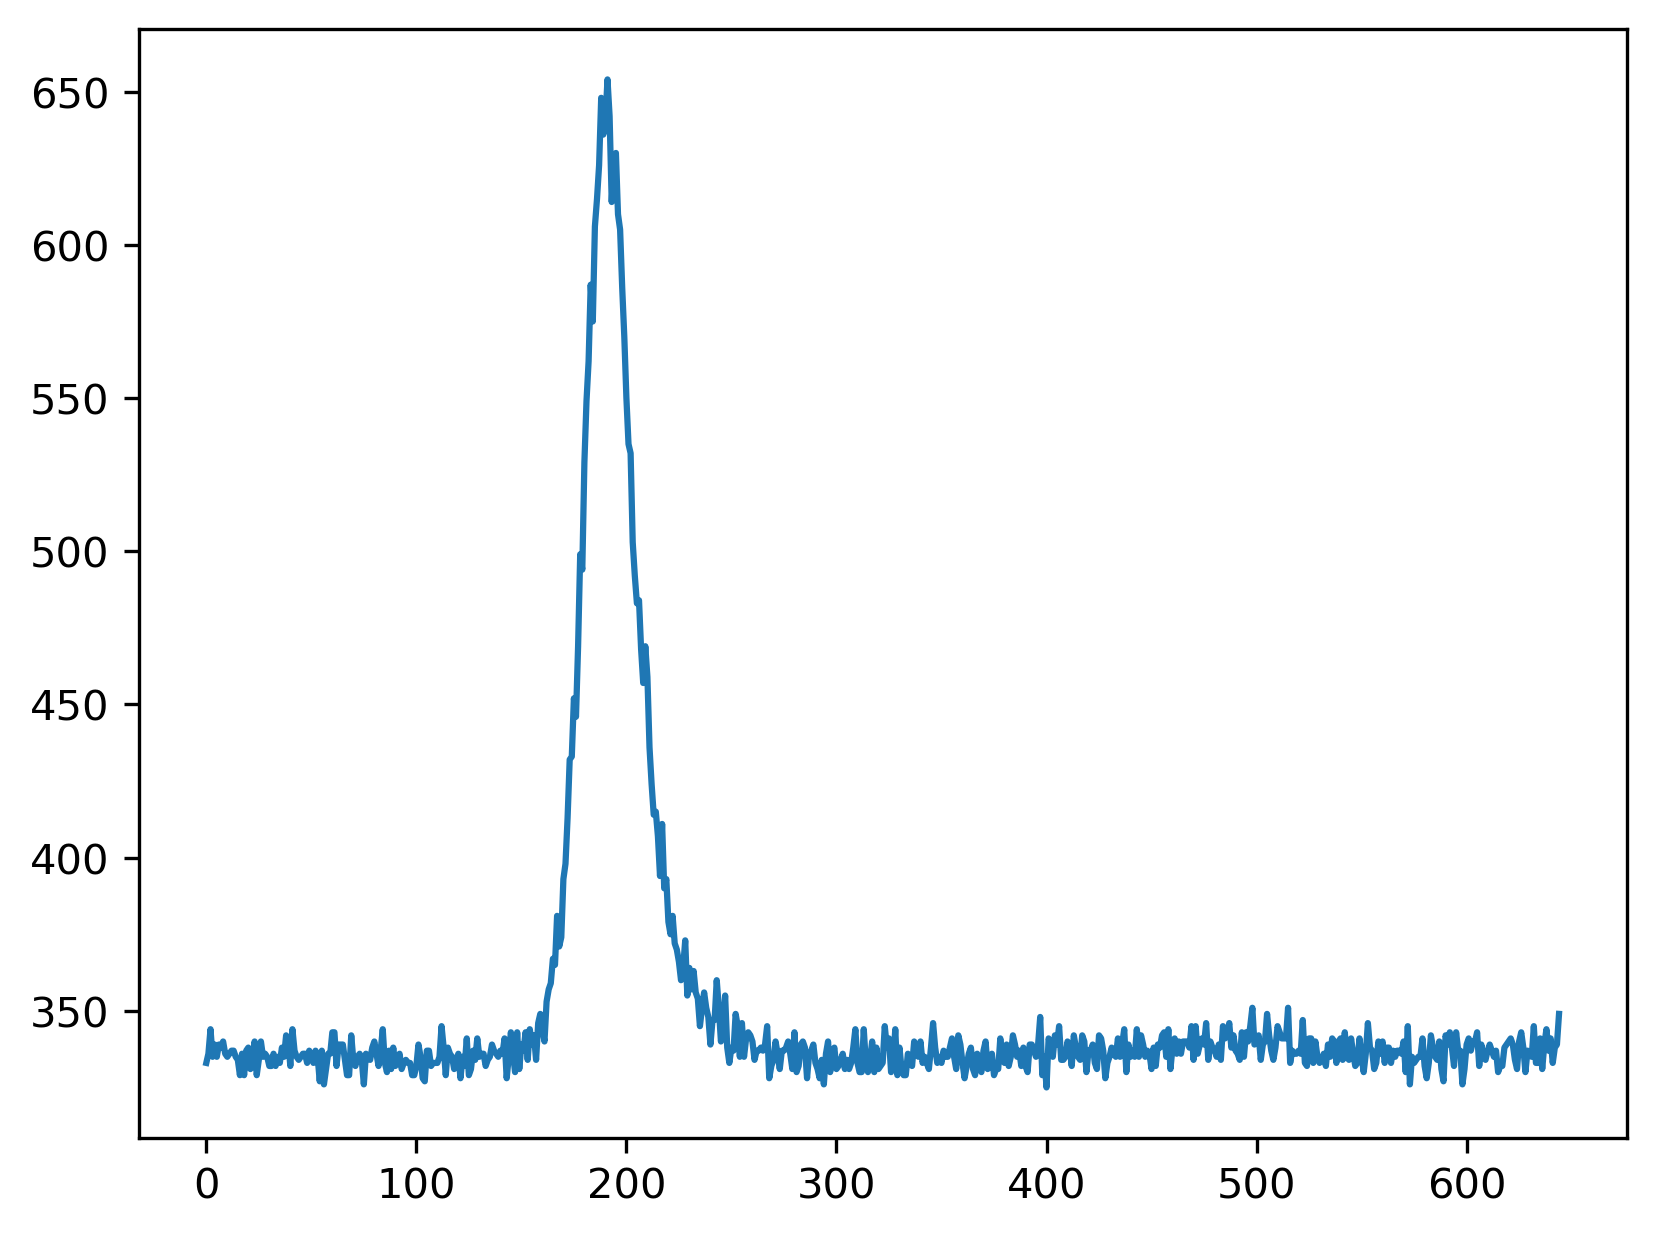

In [42]:
# Y Min
plt.plot(f2_img2[:,42,41])

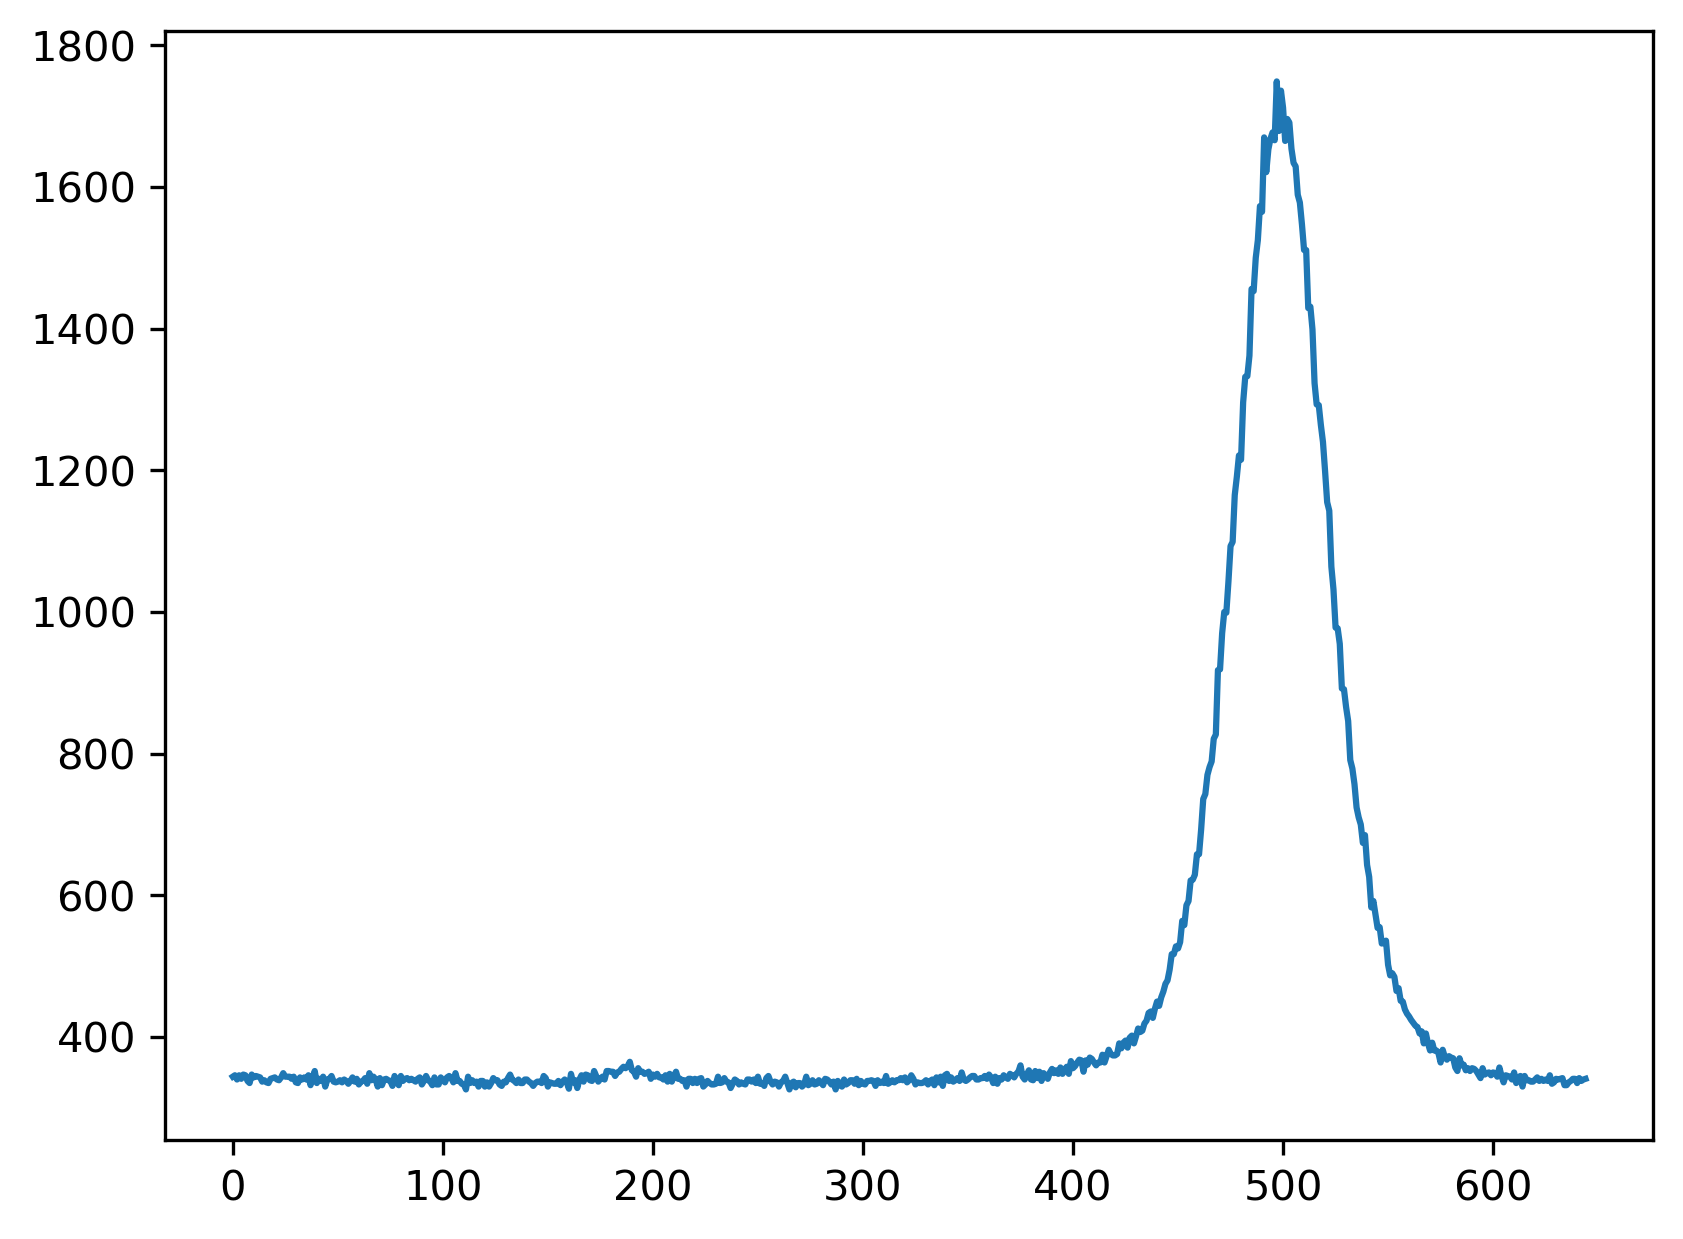

In [41]:
# Y Max
plt.plot(f2_img2[:,0,56])

Conclusion: (Difficult to determine) Y-axis is the presence of the 750nm curve and the X-axis is the relative amplitude/dominance of the 400nm curve (?)

##### The Plots

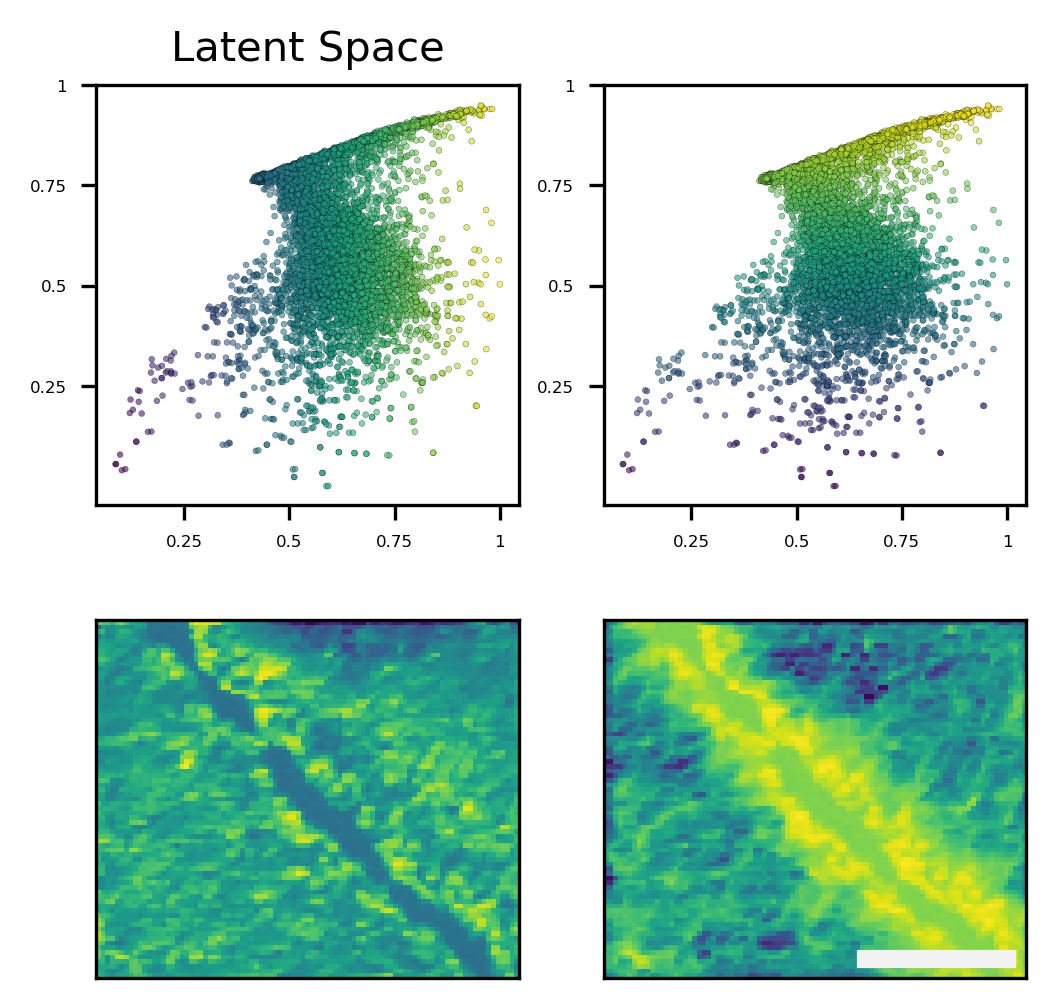

In [43]:
vae_plot("Vanilla VAE Grain 2", f2_vae_z_mean, f2_xpix, f2_ypix, 33.333333333)

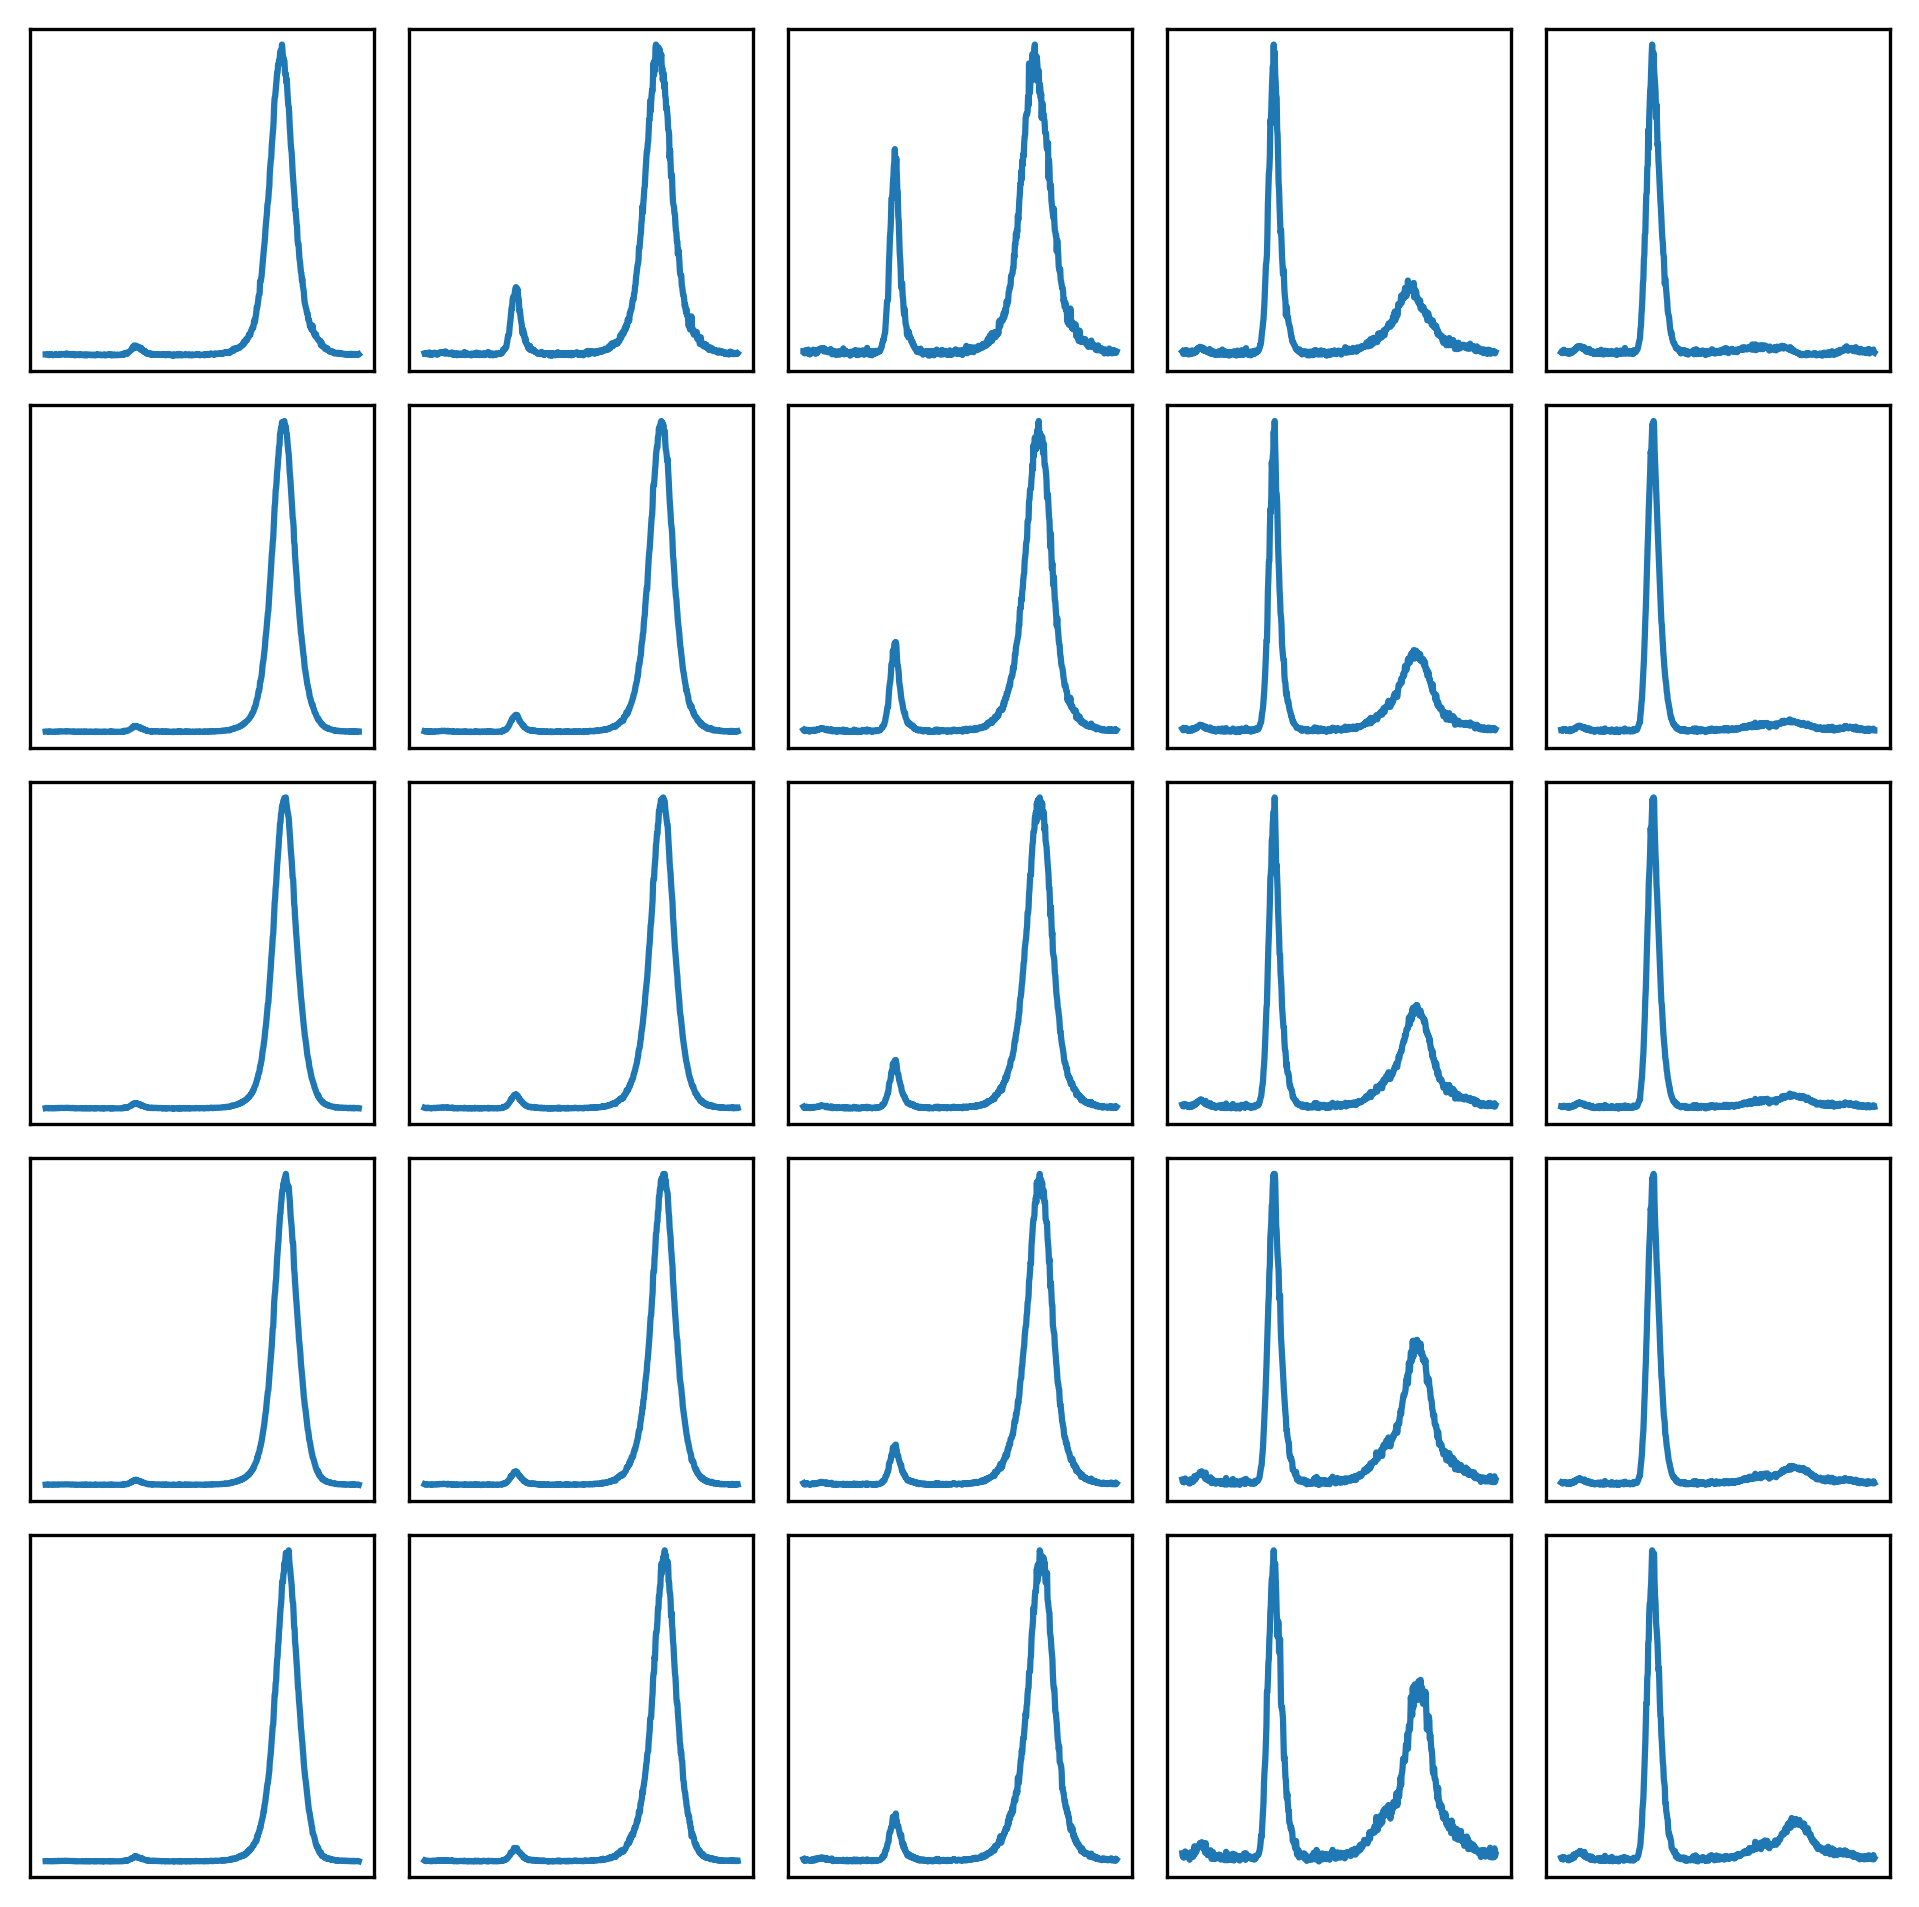

In [44]:
f2_vae.manifold2d(d=5, extent=[-5,5,-5,5]);

##### Extra

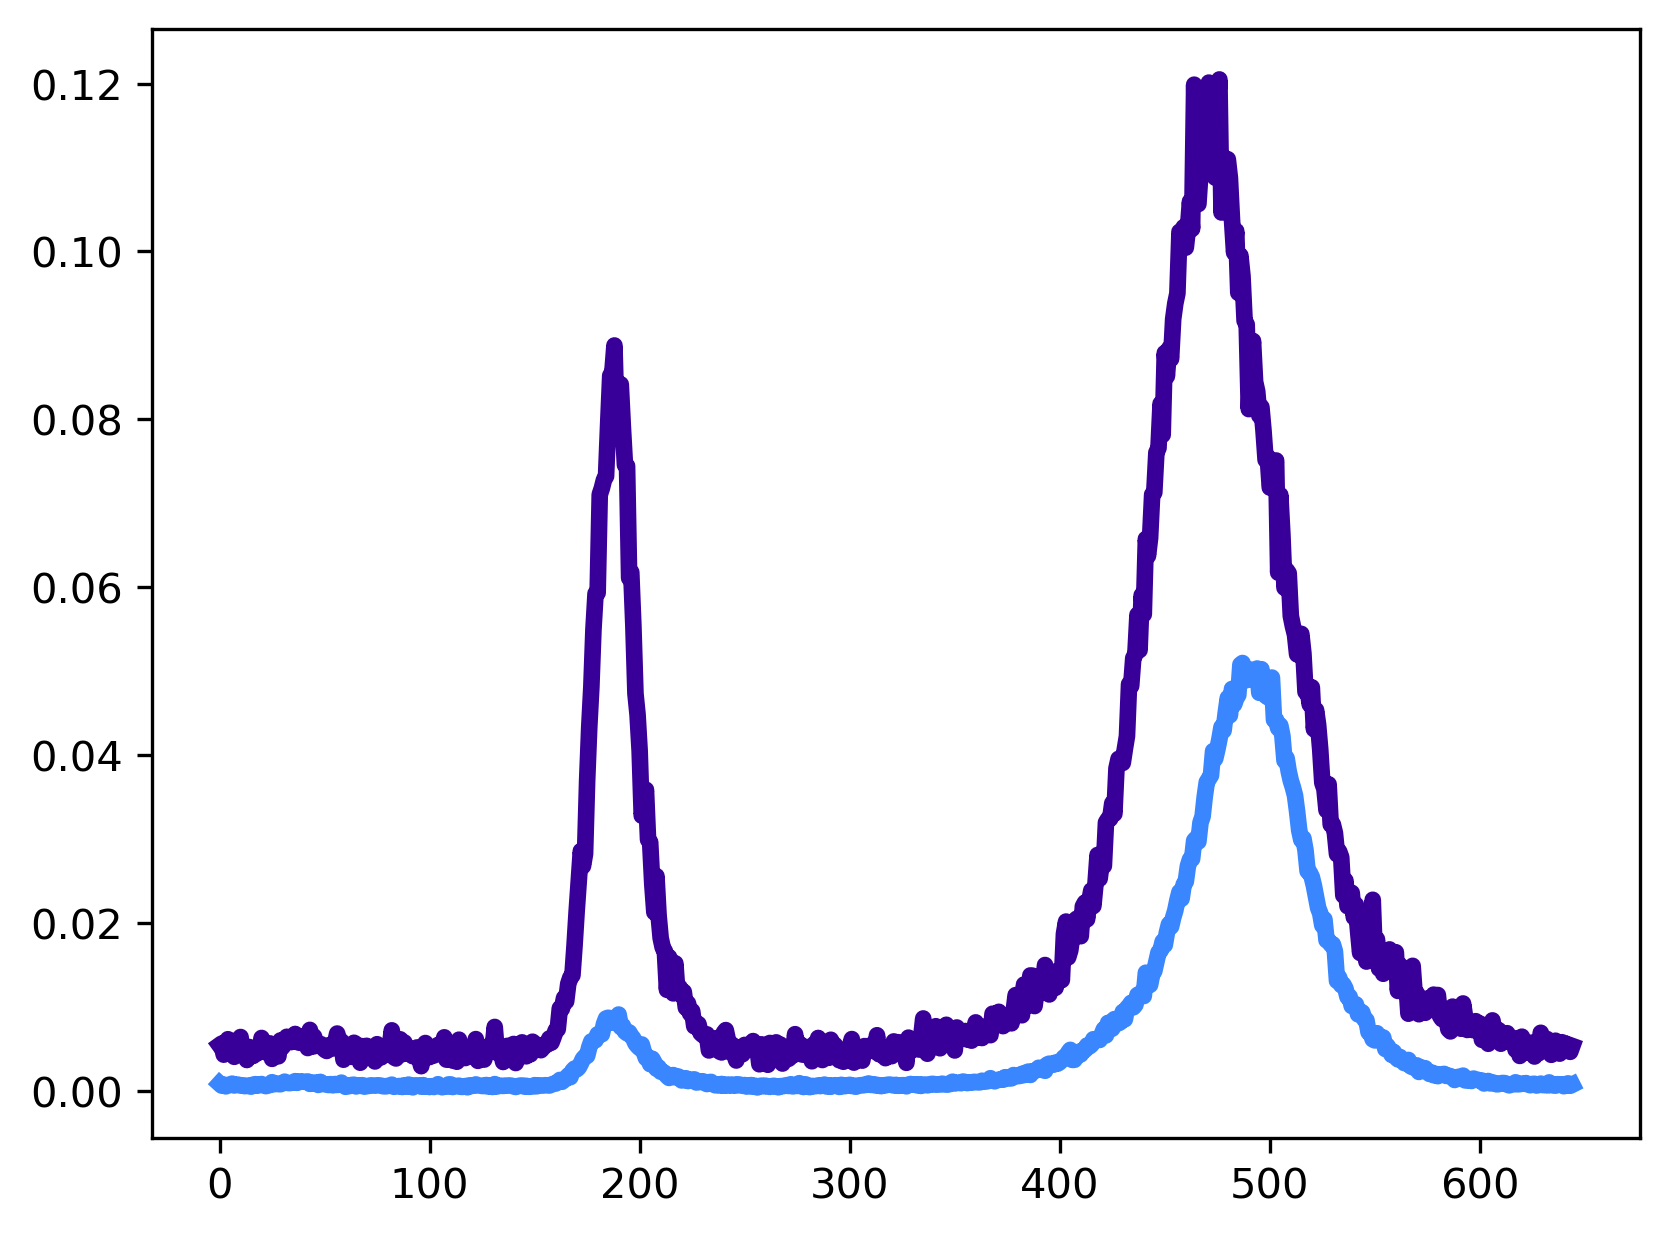

In [46]:
fig, ax = plt.subplots()
ax.plot(f2_vae.decode(torch.tensor([-2., 0.]))[0], c=color[0], lw=4)
ax.plot(f2_vae.decode(torch.tensor([2., 0.]))[0], c=color[-1], lw=4)
plt.show()

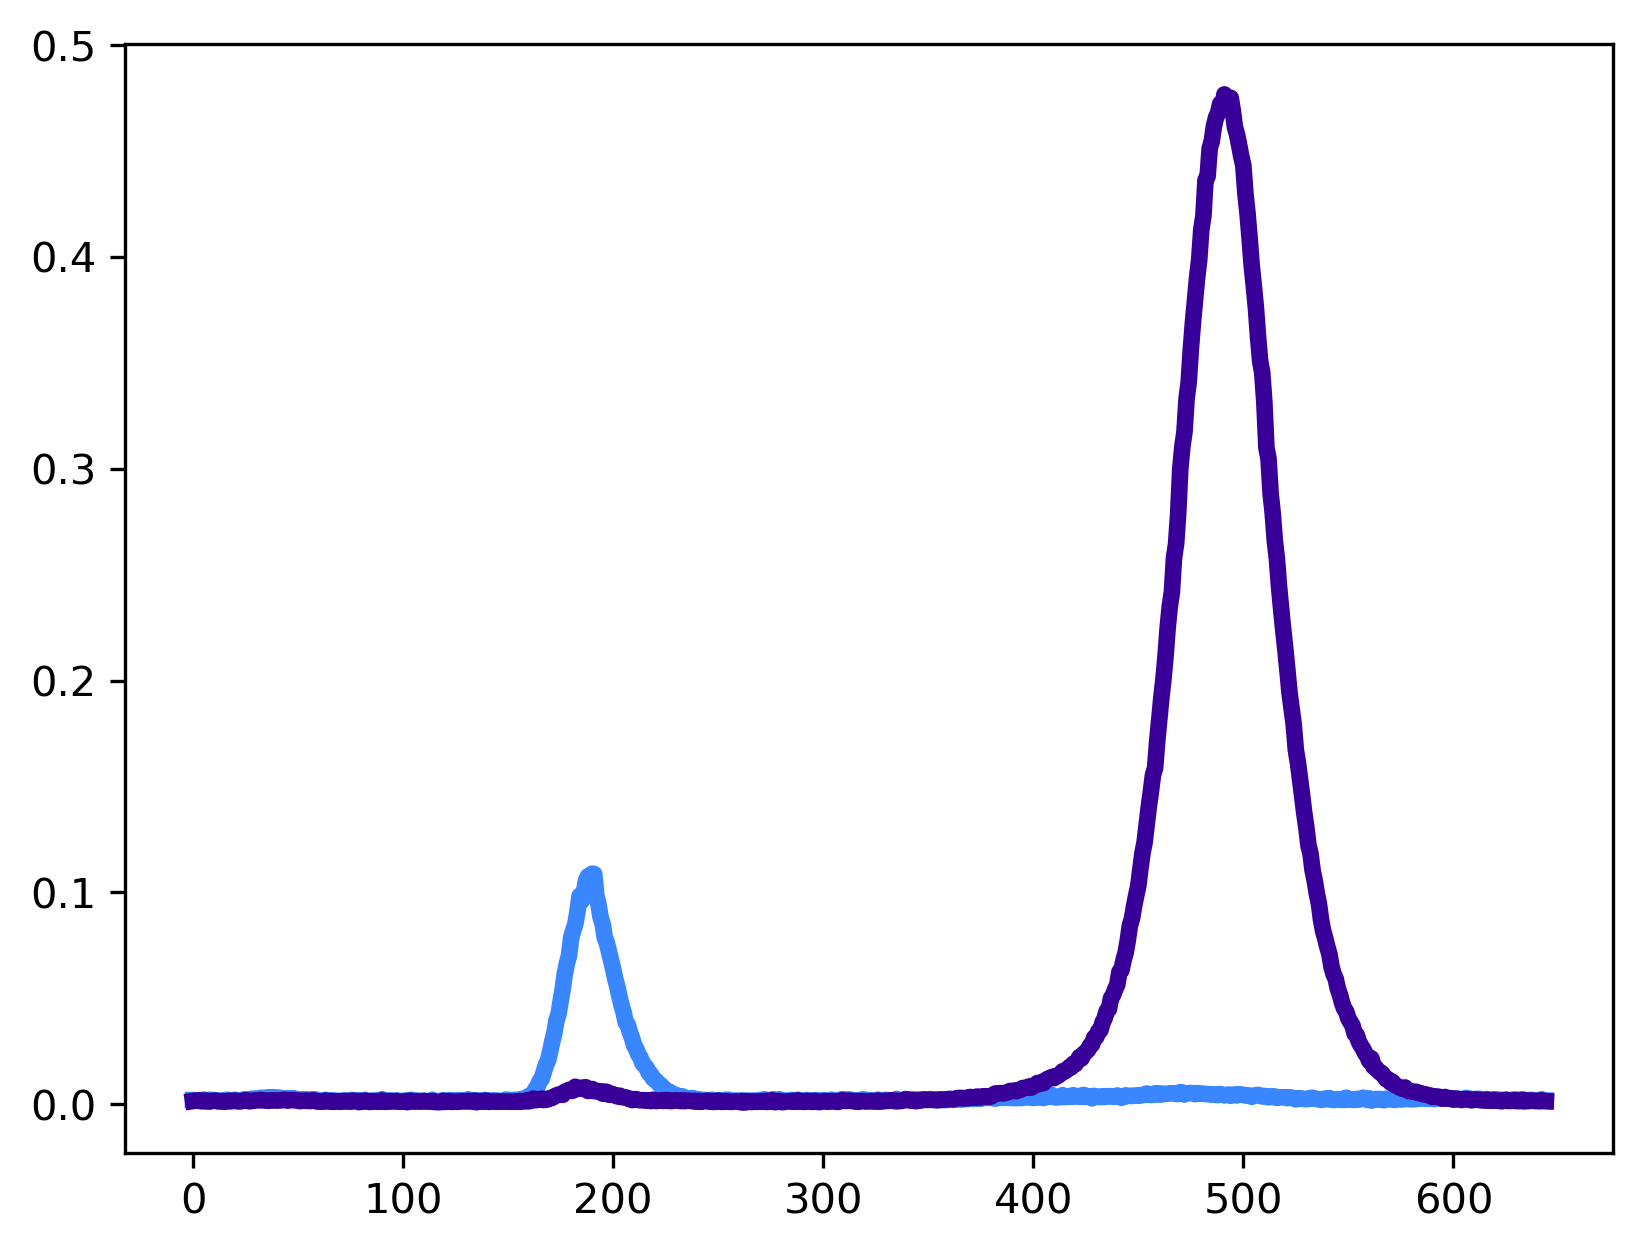

In [47]:
fig, ax = plt.subplots()
ax.plot(f2_vae.decode(torch.tensor([0., 2.]))[0], c=color[0], lw=4)
ax.plot(f2_vae.decode(torch.tensor([0., -2.]))[0], c=color[-1], lw=4)
plt.show()

### Testing different parameters (Figure 1)

#### 2) KL scale increased by an order of magnitude

range of kl scale tensor is changed from .001-.01 to .01-.1

In [ ]:
f1_train_loader_2 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=64)
f1_kl_scale_2 = torch.linspace(start=.01, end=.1, steps=50)

f1_vae_2 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_2 = pv.trainers.SVItrainer(f1_vae_2)

for e in range(50):
    sc = f1_kl_scale_2[e] if e < len(f1_kl_scale_2) else f1_kl_scale_2[-1]
    f1_vae_trainer_2.step(f1_train_loader_2, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_2.print_statistics()
        
f1_vae_z_mean_2, f1_vae_z_sd_2 = f1_vae_2.encode(f1_train_data)
f1_vae_z_mean_2 = normalize(f1_vae_z_mean_2)
f1_vae_z_sd_2 = normalize(f1_vae_z_sd_2)
vae_plot("Vanilla VAE Grain 1 Changing KL Scaling", f1_vae_z_mean_2, f1_xpix, f1_ypix, 50, True)

Epoch: 1 Training loss: 157.5961
Epoch: 11 Training loss: 145.7874
Epoch: 21 Training loss: 145.8220
Epoch: 31 Training loss: 145.8683
Epoch: 41 Training loss: 145.9091


#### 3) KL is not scaled

kl scale factor set to default (1, meaning there is no scaling)

In [ ]:
f1_train_loader_3 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=64)

f1_vae_3 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_3 = pv.trainers.SVItrainer(f1_vae_3)

for e in range(50):
    f1_vae_trainer_3.step(f1_train_loader_3, scale_factor=1)
    if e//10 == e/10:
        f1_vae_trainer_3.print_statistics()
        
f1_vae_z_mean_3, f1_vae_z_sd_3 = f1_vae_3.encode(f1_train_data)
f1_vae_z_mean_3 = normalize(f1_vae_z_mean_3)
f1_vae_z_sd_3 = normalize(f1_vae_z_sd_3)
vae_plot("Vanilla VAE Grain 1 KL Not Scaled", f1_vae_z_mean_3, f1_xpix, f1_ypix, 50, True)

##### Determining latent dimensions

In [ ]:
# X-axis
f1_vae_z_mean_2_x = f1_vae_z_mean_2[:,0].detach().cpu().numpy()
f1_vae_z_mean_2_x = f1_vae_z_mean_2_x.reshape(f1_ypix, f1_xpix)
print("X Min: ", (f1_vae_z_mean_2_x==np.min(f1_vae_z_mean_2_x)).nonzero())
print("X Max: ", (f1_vae_z_mean_2_x==np.max(f1_vae_z_mean_2_x)).nonzero())

Same result as the x-axis for original, scaled kl. All the points have been compressed into a single dimension.

#### 4) Batch size changed from 64 to 128

In [ ]:
f1_train_loader_4 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=128)

f1_vae_4 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_4 = pv.trainers.SVItrainer(f1_vae_4)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_4.step(f1_train_loader_4, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_4.print_statistics()
        
f1_vae_z_mean_4, f1_vae_z_sd_4 = f1_vae_4.encode(f1_train_data)
f1_vae_z_mean_4 = normalize(f1_vae_z_mean_4)
f1_vae_z_sd_4 = normalize(f1_vae_z_sd_4)
vae_plot("Vanilla VAE Grain 1 Batch Size 128", f1_vae_z_mean_4, f1_xpix, f1_ypix, 50, True)

#### 5) Batch size changed from 64 to 512

In [ ]:
f1_train_loader_5 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=512)

f1_vae_5 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_5 = pv.trainers.SVItrainer(f1_vae_5)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_5.step(f1_train_loader_5, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_5.print_statistics()
        
f1_vae_z_mean_5, f1_vae_z_sd_5 = f1_vae_5.encode(f1_train_data)
f1_vae_z_mean_5 = normalize(f1_vae_z_mean_5)
f1_vae_z_sd_5 = normalize(f1_vae_z_sd_5)
vae_plot("Vanilla VAE Grain 1 Batch Size 512", f1_vae_z_mean_5, f1_xpix, f1_ypix, 50, True)

##### Determining latent dimensions

In [ ]:
# X-axis
f1_vae_z_mean_5_x = f1_vae_z_mean_5[:,0].detach().cpu().numpy()
f1_vae_z_mean_5_x = f1_vae_z_mean_5_x.reshape(f1_ypix, f1_xpix)
print("X Min: ", (f1_vae_z_mean_5_x==np.min(f1_vae_z_mean_5_x)).nonzero())
print("X Max: ", (f1_vae_z_mean_5_x==np.max(f1_vae_z_mean_5_x)).nonzero())

In [ ]:
# X min
plt.plot(f1_img2[:,36,17])
plt.show()

In [ ]:
# X max
plt.plot(f1_img2[:,41,1])
plt.show()

#### 6) Batch sized changed from 64 to 256

In [ ]:
f1_train_loader_6 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=256)

f1_vae_6 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_6 = pv.trainers.SVItrainer(f1_vae_6)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_6.step(f1_train_loader_6, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_6.print_statistics()
        
f1_vae_z_mean_6, f1_vae_z_sd_6 = f1_vae_6.encode(f1_train_data)
f1_vae_z_mean_6 = normalize(f1_vae_z_mean_6)
f1_vae_z_sd_6 = normalize(f1_vae_z_sd_6)
vae_plot("Vanilla VAE Grain 1 Batch Size 256", f1_vae_z_mean_6, f1_xpix, f1_ypix, 50, True)

##### Determining Latent Dimensions

In [ ]:
# X-axis
f1_vae_z_mean_6_x = f1_vae_z_mean_6[:,0].detach().cpu().numpy()
f1_vae_z_mean_6_x = f1_vae_z_mean_6_x.reshape(f1_ypix, f1_xpix)
print("X Min:", (f1_vae_z_mean_6_x==np.min(f1_vae_z_mean_6_x)).nonzero())
print("X Max:", (f1_vae_z_mean_6_x==np.max(f1_vae_z_mean_6_x)).nonzero())

In [ ]:
f1_vae_z_mean_6_x_sort = np.dstack(
    np.unravel_index(np.argsort(f1_vae_z_mean_6_x.ravel()), (f1_ypix, f1_xpix)))
f1_vae_z_mean_6_x_sort = np.squeeze(f1_vae_z_mean_6_x_sort)

In [ ]:
spectra_plot(f1_img2, f1_vae_z_mean_6_x_sort, f1_xpix, f1_ypix, f1_wav, 'Figure 1: X-axis')

In [ ]:
# Y-axis
f1_vae_z_mean_6_y = f1_vae_z_mean_6[:,1].detach().cpu().numpy()
f1_vae_z_mean_6_y = f1_vae_z_mean_6_y.reshape(f1_ypix, f1_xpix)
print("Y Min: ", (f1_vae_z_mean_6_y==np.min(f1_vae_z_mean_6_y)).nonzero())
print("Y Max: ", (f1_vae_z_mean_6_y==np.max(f1_vae_z_mean_6_y)).nonzero())

In [ ]:
f1_vae_z_mean_6_y_sort = np.dstack(
    np.unravel_index(np.argsort(f1_vae_z_mean_6_y.ravel()), (f1_ypix, f1_xpix)))
f1_vae_z_mean_6_y_sort = np.squeeze(f1_vae_z_mean_6_y_sort)

In [ ]:
spectra_plot(f1_img2, f1_vae_z_mean_6_y_sort, f1_xpix, f1_ypix, f1_wav, 'Figure 1: Y-axis')

##### Standard deviation plot

In [ ]:
vae_plot(f1_vae_z_sd_6, f1_xpix, f1_ypix, 50)

#### 7) KL scale decreased by an order of magnitude

In [ ]:
f1_train_loader_7 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=64)
f1_kl_scale_7 = torch.linspace(start=.0001, end=.001, steps=50)

f1_vae_7 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_7 = pv.trainers.SVItrainer(f1_vae_7)

for e in range(50):
    sc = f1_kl_scale_7[e] if e < len(f1_kl_scale_7) else f1_kl_scale_7[-1]
    f1_vae_trainer_7.step(f1_train_loader_7, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_7.print_statistics()

In [ ]:
f1_vae_z_mean_7, f1_vae_z_sd_7 = f1_vae_7.encode(f1_train_data)
f1_vae_z_mean_7 = normalize(f1_vae_z_mean_7)
f1_vae_z_sd_7 = normalize(f1_vae_z_sd_7)
vae_plot(f1_vae_z_mean_7, f1_xpix, f1_ypix, 50)

#### 8) KL scaled with larger step sizes

In [ ]:
f1_train_loader_8 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=64)
f1_kl_scale_8 = torch.linspace(start=.0001, end=.1, steps=50)

f1_vae_8 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_8 = pv.trainers.SVItrainer(f1_vae_8)

for e in range(50):
    sc = f1_kl_scale_8[e] if e < len(f1_kl_scale_8) else f1_kl_scale_8[-1]
    f1_vae_trainer_8.step(f1_train_loader_8, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_8.print_statistics()

In [ ]:
f1_vae_z_mean_8, f1_vae_z_sd_8 = f1_vae_8.encode(f1_train_data)
f1_vae_z_mean_8 = normalize(f1_vae_z_mean_8)
f1_vae_z_sd_8 = normalize(f1_vae_z_sd_8)
vae_plot(f1_vae_z_mean_8, f1_xpix, f1_ypix, 50)

#### 9) Training with more epochs (changed from 50 to 100)

In [ ]:
f1_train_loader_9 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=64)
f1_kl_scale_9 = torch.linspace(start=.001, end=.01, steps=100)

f1_vae_9 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_9 = pv.trainers.SVItrainer(f1_vae_9)

for e in range(100):
    sc = f1_kl_scale_9[e] if e < len(f1_kl_scale_9) else f1_kl_scale_9[-1]
    f1_vae_trainer_9.step(f1_train_loader_9, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_9.print_statistics()

In [ ]:
f1_vae_z_mean_9, f1_vae_z_sd_9 = f1_vae_9.encode(f1_train_data)
f1_vae_z_mean_9 = normalize(f1_vae_z_mean_9)
f1_vae_z_sd_9 = normalize(f1_vae_z_sd_9)
vae_plot(f1_vae_z_mean_9, f1_xpix, f1_ypix, 50)

#### 10) Batch size 256, continuous bernoulli sampling

In [ ]:
f1_train_loader_10 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=256)

f1_vae_10 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="continuous_bernoulli")
f1_vae_trainer_10 = pv.trainers.SVItrainer(f1_vae_10)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_10.step(f1_train_loader_10, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_10.print_statistics()

In [ ]:
f1_vae_z_mean_10, f1_vae_z_sd_10 = f1_vae_10.encode(f1_train_data)
f1_vae_z_mean_10 = normalize(f1_vae_z_mean_10)
f1_vae_z_sd_10 = normalize(f1_vae_z_sd_10)
vae_plot(f1_vae_z_mean_10, f1_xpix, f1_ypix, 50)

#### 11) Batch size 256, Bernoulli sampling

In [ ]:
f1_train_loader_11 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=256)

f1_vae_11 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="bernoulli")
f1_vae_trainer_11 = pv.trainers.SVItrainer(f1_vae_11)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_11.step(f1_train_loader_11, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_11.print_statistics()

In [ ]:
f1_vae_z_mean_11, f1_vae_z_sd_11 = f1_vae_11.encode(f1_train_data)
f1_vae_z_mean_11 = normalize(f1_vae_z_mean_11)
f1_vae_z_sd_11 = normalize(f1_vae_z_sd_11)
vae_plot(f1_vae_z_mean_11, f1_xpix, f1_ypix, 50)

#### 12) Changed dimension added (unsqueezed) to training data

In [ ]:
f1_train_loader_12 = pv.utils.init_dataloader(f1_train_data.unsqueeze(2), batch_size=256)

f1_vae_12 = pv.models.iVAE(f1_in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_12 = pv.trainers.SVItrainer(f1_vae_12)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_12.step(f1_train_loader_12, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_12.print_statistics()

In [ ]:
f1_vae_z_mean_12, f1_vae_z_sd_12 = f1_vae_12.encode(f1_train_data)
f1_vae_z_mean_12 = normalize(f1_vae_z_mean_12)
f1_vae_z_sd_12 = normalize(f1_vae_z_sd_12)
vae_plot(f1_vae_z_mean_12, f1_xpix, f1_ypix, 50)

#### 13) Inputting 3D data

In [ ]:
f1_denoised_3d_norm = normalize(f1_denoised_1d_transpose).reshape(f1_ypix, f1_xpix, f1_zpix)

f1_denoised_3d_norm_t = torch.from_numpy(np.array(f1_denoised_3d_norm).astype('float64')).float()
f1_n_samples_13 = f1_denoised_2d_norm_t.size()[0]*f1_denoised_2d_norm_t.size()[1] # number of spectral points
f1_l_signal_13 = f1_denoised_3d_norm_t.size()[2] # number of spectra

f1_train_data_13 = f1_denoised_3d_norm_t.clone()
f1_train_loader_13 = pv.utils.init_dataloader(f1_train_data_13, batch_size=256)

f1_in_dim_13 = (f1_l_signal_13,)

f1_vae_13 = pv.models.iVAE(f1_in_dim_13, latent_dim=2, invariances=None, sampler_d="gaussian")
f1_vae_trainer_13 = pv.trainers.SVItrainer(f1_vae_13)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_13.step(f1_train_loader_13, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_13.print_statistics()

In [ ]:
#f1_denoised_3d_norm_t.shape

## Changing input data to trained models

### Inputting figure 2 into model trained on figure 1

In [ ]:
f2on1_vae_z_mean, f2on1_vae_z_sd = f1_vae.encode(f2_train_data)
f2on1_vae_z_mean = normalize(f2on1_vae_z_mean)
f2on1_vae_z_sd = normalize(f2on1_vae_z_sd)

In [ ]:
vae_plot(f2on1_vae_z_mean, f2_xpix, f2_ypix, 33.333333333)

In [ ]:
f2on1_vae_z_mean_6, f2on1_vae_z_sd_6 = f1_vae_6.encode(f2_train_data)
f2on1_vae_z_mean_6 = normalize(f2on1_vae_z_mean_6)
f2on1_vae_z_sd_6 = normalize(f2on1_vae_z_sd_6)

In [ ]:
vae_plot(f2on1_vae_z_mean_6, f2_xpix, f2_ypix, 33.333333333)

### Inputting figure 1 into model trained on figure 2

In [ ]:
f1on2_vae_z_mean, f1on2_vae_z_sd = f2_vae.encode(f1_train_data)
f1on2_vae_z_mean = normalize(f1on2_vae_z_mean)
f1on2_vae_z_sd = normalize(f1on2_vae_z_sd)

In [ ]:
vae_plot(f1on2_vae_z_mean, f1_xpix, f1_ypix, 50)

## Invariant VAE (3 latent dimensions)

### Figure 1

#### Code

In [ ]:
f1_vae_3dim = pv.models.iVAE(f1_in_dim, latent_dim=3, invariances=None, sampler_d="gaussian")
f1_vae_trainer_3dim = pv.trainers.SVItrainer(f1_vae_3dim)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_3dim.step(f1_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_3dim.print_statistics()

In [ ]:
f1_vae_z_mean_3dim, f1_vae_z_sd_3dim = f1_vae_3dim.encode(f1_denoised_2d_norm_t)

In [ ]:
f1_vae_z_mean_3dim = normalize(f1_vae_z_mean_3dim)
f1_vae_z_sd_3dim = normalize(f1_vae_z_sd_3dim)

#### Determining latent dimensions

In [ ]:
# X-axis
# Convert to np array and reshape to 2d
f1_vae_z_mean_3dim_x = f1_vae_z_mean_3dim[:,0].detach().cpu().numpy()
f1_vae_z_mean_3dim_x = f1_vae_z_mean_3dim_x.reshape(f1_ypix, f1_xpix)
print((f1_vae_z_mean_3dim_x==np.min(f1_vae_z_mean_3dim_x)).nonzero())
print((f1_vae_z_mean_3dim_x==np.max(f1_vae_z_mean_3dim_x)).nonzero())

In [ ]:
# X-axis min
plt.plot(f1_img2[:,14,45])
plt.show()

In [ ]:
# X-axis max
plt.plot(f1_img2[:,62,23])
plt.show()

In [ ]:
# Y-axis
f1_vae_z_mean_3dim_y = f1_vae_z_mean_3dim[:,1].detach().cpu().numpy()
f1_vae_z_mean_3dim_y = f1_vae_z_mean_3dim_y.reshape(f1_ypix, f1_xpix)
print((f1_vae_z_mean_3dim_y==np.min(f1_vae_z_mean_3dim_y)).nonzero())
print((f1_vae_z_mean_3dim_y==np.max(f1_vae_z_mean_3dim_y)).nonzero())

In [ ]:
# Y-axis min
plt.plot(f1_img2[:,14,45])
plt.show()

In [ ]:
# Y-axis max
plt.plot(f1_img2[:,16,44])
plt.show()

In [ ]:
# Z-axis
f1_vae_z_mean_3dim_z = f1_vae_z_mean_3dim[:,2].detach().cpu().numpy()
f1_vae_z_mean_3dim_z = f1_vae_z_mean_3dim_z.reshape(f1_ypix, f1_xpix)
print((f1_vae_z_mean_3dim_z==np.min(f1_vae_z_mean_3dim_z)).nonzero())
print((f1_vae_z_mean_3dim_z==np.max(f1_vae_z_mean_3dim_z)).nonzero())

In [ ]:
# Z-axis min
plt.plot(f1_img2[:,6,95])
plt.show()

In [ ]:
# Z-axis max
plt.plot(f1_img2[:,32,23])
plt.show()

#### Plot

In [ ]:
vae_plot(f1_vae_z_mean_3dim, f1_xpix, f1_ypix, 50)

### Figure 2

#### Code

In [ ]:
f2_vae_3dim = pv.models.iVAE(f2_in_dim, latent_dim=3, invariances=None, sampler_d="gaussian")
f2_vae_trainer_3dim = pv.trainers.SVItrainer(f2_vae_3dim)

for e in range(50):
    sc = f2_kl_scale[e] if e < len(f2_kl_scale) else f2_kl_scale[-1]
    f2_vae_trainer_3dim.step(f2_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f2_vae_trainer_3dim.print_statistics()

In [ ]:
f2_vae_z_mean_3dim, f2_vae_z_sd_3dim = f2_vae_3dim.encode(f2_denoised_2d_norm_t)
f2_vae_z_mean_3dim = normalize(f2_vae_z_mean_3dim)
f2_vae_z_sd_3dim = normalize(f2_vae_z_sd_3dim)

#### Determining Laten Variables

In [ ]:
# X-axis
# Convert to np array and reshape to 2d
f2_vae_z_mean_3dim_x = f2_vae_z_mean_3dim[:,0].detach().cpu().numpy()
f2_vae_z_mean_3dim_x = f2_vae_z_mean_3dim_x.reshape(f2_ypix, f2_xpix)
print("X Min: ", (f2_vae_z_mean_3dim_x==np.min(f2_vae_z_mean_3dim_x)).nonzero())
print("X Max: ", (f2_vae_z_mean_3dim_x==np.max(f2_vae_z_mean_3dim_x)).nonzero())

In [ ]:
# X-axis min
plt.plot(f2_img2[:,52,64])
plt.show()

In [ ]:
# X-axis max
plt.plot(f2_img2[:,0,56])
plt.show()

In [ ]:
# Y-axis
f2_vae_z_mean_3dim_y = f2_vae_z_mean_3dim[:,1].detach().cpu().numpy()
f2_vae_z_mean_3dim_y = f2_vae_z_mean_3dim_y.reshape(f2_ypix, f2_xpix)
print("Y Min: ", (f2_vae_z_mean_3dim_y==np.min(f2_vae_z_mean_3dim_y)).nonzero())
print("Y Max: ", (f2_vae_z_mean_3dim_y==np.max(f2_vae_z_mean_3dim_y)).nonzero())

In [ ]:
# Y-axis min
plt.plot(f2_img2[:,9,39])
plt.show()

In [ ]:
# Y-axis max
plt.plot(f2_img2[:,44,14])
plt.show()

In [ ]:
# Z-axis
f2_vae_z_mean_3dim_z = f2_vae_z_mean_3dim[:,2].detach().cpu().numpy()
f2_vae_z_mean_3dim_z = f2_vae_z_mean_3dim_z.reshape(f2_ypix, f2_xpix)
print("Z Min: ", (f2_vae_z_mean_3dim_z==np.min(f2_vae_z_mean_3dim_z)).nonzero())
print("Z Max: ", (f2_vae_z_mean_3dim_z==np.max(f2_vae_z_mean_3dim_z)).nonzero())

In [ ]:
# Z-axis min
plt.plot(f2_img2[:,10,39])
plt.show()

In [ ]:
# Z-axis max
plt.plot(f2_img2[:,0,56])
plt.show()

#### Plot

In [ ]:
vae_plot(f2_vae_z_mean_3dim, f2_xpix, f2_ypix, 33.333333333)

### Testing different parameters (Figure 1)

#### Batch size changed from 64 to 256

In [ ]:
f1_train_loader_3dim_2 = pv.utils.init_dataloader(f1_train_data.unsqueeze(1), batch_size=256)

f1_vae_3dim_2 = pv.models.iVAE(f1_in_dim, latent_dim=3, invariances=None, sampler_d="gaussian")
f1_vae_trainer_3dim_2 = pv.trainers.SVItrainer(f1_vae_3dim_2)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_vae_trainer_3dim_2.step(f1_train_loader_3dim_2, scale_factor=sc)
    if e//10 == e/10:
        f1_vae_trainer_3dim_2.print_statistics()

In [ ]:
f1_vae_z_mean_3dim_2, f1_vae_z_sd_3dim_2 = f1_vae_3dim_2.encode(f1_denoised_2d_norm_t)
f1_vae_z_mean_3dim_2 = normalize(f1_vae_z_mean_3dim_2)
f1_vae_z_sd_3dim_2 = normalize(f1_vae_z_sd_3dim_2)

In [ ]:
vae_plot(f1_vae_z_mean_3dim_2, f1_xpix, f1_ypix, 50)

##### Determining Latent Dimensions

In [ ]:
# X-axis
f1_vae_z_mean_3dim_2_x = f1_vae_z_mean_3dim_2[:,0].detach().cpu().numpy()
f1_vae_z_mean_3dim_2_x = f1_vae_z_mean_3dim_2_x.reshape(f1_ypix, f1_xpix)
print("X Min: ", (f1_vae_z_mean_3dim_2_x==np.min(f1_vae_z_mean_3dim_2_x)).nonzero())
print("X Max: ", (f1_vae_z_mean_3dim_2_x==np.max(f1_vae_z_mean_3dim_2_x)).nonzero())
f1_vae_z_mean_3dim_2_x_sort = np.dstack(
    np.unravel_index(np.argsort(f1_vae_z_mean_3dim_2_x.ravel()), (f1_ypix, f1_xpix)))
f1_vae_z_mean_3dim_2_x_sort = np.squeeze(f1_vae_z_mean_3dim_2_x_sort)

In [ ]:
spectra_plot(f1_img2, f1_vae_z_mean_3dim_2_x_sort, f1_xpix, f1_ypix, f1_wav, 'Figure 1 (3D): X-axis')

In [ ]:
# Y-axis
f1_vae_z_mean_3dim_2_y = f1_vae_z_mean_3dim_2[:,1].detach().cpu().numpy()
f1_vae_z_mean_3dim_2_y = f1_vae_z_mean_3dim_2_y.reshape(f1_ypix, f1_xpix)
print("Y Min: ", (f1_vae_z_mean_3dim_2_y==np.min(f1_vae_z_mean_3dim_2_y)).nonzero())
print("Y Max: ", (f1_vae_z_mean_3dim_2_y==np.max(f1_vae_z_mean_3dim_2_y)).nonzero())
f1_vae_z_mean_3dim_2_y_sort = np.dstack(
    np.unravel_index(np.argsort(f1_vae_z_mean_3dim_2_y.ravel()), (f1_ypix, f1_xpix)))
f1_vae_z_mean_3dim_2_y_sort = np.squeeze(f1_vae_z_mean_3dim_2_y_sort)

In [ ]:
spectra_plot(f1_img2, f1_vae_z_mean_3dim_2_y_sort, f1_xpix, f1_ypix, f1_wav, 'Figure 1 (3D): Y-axis')

In [ ]:
# Z-axis
f1_vae_z_mean_3dim_2_z = f1_vae_z_mean_3dim_2[:,2].detach().cpu().numpy()
f1_vae_z_mean_3dim_2_z = f1_vae_z_mean_3dim_2_z.reshape(f1_ypix, f1_xpix)
print("Y Min: ", (f1_vae_z_mean_3dim_2_z==np.min(f1_vae_z_mean_3dim_2_z)).nonzero())
print("Y Max: ", (f1_vae_z_mean_3dim_2_z==np.max(f1_vae_z_mean_3dim_2_z)).nonzero())
f1_vae_z_mean_3dim_2_z_sort = np.dstack(
    np.unravel_index(np.argsort(f1_vae_z_mean_3dim_2_z.ravel()), (f1_ypix, f1_xpix)))
f1_vae_z_mean_3dim_2_z_sort = np.squeeze(f1_vae_z_mean_3dim_2_z_sort)

In [ ]:
spectra_plot(f1_img2, f1_vae_z_mean_3dim_2_z_sort, f1_xpix, f1_ypix, f1_wav, 'Figure 1 (3D): Z-axis')

## Joint Invariant VAE

Variational autoencoder for learning (jointly) discrete and continuous latent representations of data while enforcing rotational, translational, and scale invariances.

### Figure 1

#### Code

In [ ]:
# !0 discrete dimensions
f1_jivae = pv.models.jiVAE(f1_in_dim, latent_dim=2, discrete_dim=10, invariances=None, 
                           sampler_d="gaussian")
f1_jivae_trainer = pv.trainers.SVItrainer(f1_jivae)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_jivae_trainer.step(f1_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f1_jivae_trainer.print_statistics()

In [ ]:
f1_vae.encode(f1_denoised_2d_norm_t)[0].shape

In [ ]:
f1_jivae.encode(f1_denoised_2d_norm_t)[0].shape

In [ ]:
f1_jivae_z_mean = f1_jivae.encode(f1_denoised_2d_norm_t)[0]
f1_jivae_z_sd = f1_jivae.encode(f1_denoised_2d_norm_t)[1]
f1_jivae_z_mean = normalize(f1_jivae_z_mean)
f1_jivae_z_sd = normalize(f1_jivae_z_sd)

In [ ]:
# 2 discrete dimensions
f1_jivae_2 = pv.models.jiVAE(f1_in_dim, latent_dim=2, discrete_dim=2, invariances=None, 
                           sampler_d="gaussian")
f1_jivae_2_trainer = pv.trainers.SVItrainer(f1_jivae_2)

for e in range(50):
    sc = f1_kl_scale[e] if e < len(f1_kl_scale) else f1_kl_scale[-1]
    f1_jivae_2_trainer.step(f1_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f1_jivae_2_trainer.print_statistics()

In [ ]:
f1_jivae_2_z_mean = f1_jivae_2.encode(f1_denoised_2d_norm_t)[0]
f1_jivae_2_z_sd = f1_jivae_2.encode(f1_denoised_2d_norm_t)[1]
f1_jivae_2_z_mean = normalize(f1_jivae_2_z_mean)
f1_jivae_2_z_sd = normalize(f1_jivae_2_z_sd)

#### Plot

In [ ]:
# !0 discrete dimensions
vae_plot(f1_jivae_z_mean, f1_xpix, f1_ypix, 50)

In [ ]:
# 2 discrete dimensions
vae_plot(f1_jivae_2_z_mean, f1_xpix, f1_ypix, 50)

#### Determining latent dimensions for JIVAE with 2 discrete dimensions

In [ ]:
f1_jivae_2.manifold2d(d=5, extent=[-5,5,-5,5]);

In [ ]:
# X-axis
# Convert to np array and reshape to 2d
f1_jivae_2_z_mean_x = f1_jivae_2_z_mean[:,0].detach().cpu().numpy()
f1_jivae_2_z_mean_x = f1_jivae_2_z_mean_x.reshape(f1_ypix, f1_xpix)
print("X Min: ", (f1_jivae_2_z_mean_x==np.min(f1_jivae_2_z_mean_x)).nonzero())
print("X Max: ", (f1_jivae_2_z_mean_x==np.max(f1_jivae_2_z_mean_x)).nonzero())

In [ ]:
# X min
plt.plot(f1_img2[:,27,24])
plt.show()

In [ ]:
# X max
plt.plot(f1_img2[:,41,0])
plt.show()

In [ ]:
# Y-axis
f1_jivae_2_z_mean_y = f1_jivae_2_z_mean[:,1].detach().cpu().numpy()
f1_jivae_2_z_mean_y = f1_jivae_2_z_mean_y.reshape(f1_ypix, f1_xpix)
print("Y Min: ", (f1_jivae_2_z_mean_y==np.min(f1_jivae_2_z_mean_y)).nonzero())
print("Y Max: ", (f1_jivae_2_z_mean_y==np.max(f1_jivae_2_z_mean_y)).nonzero())

In [ ]:
# Y min
plt.plot(f1_img2[:,13,49])
plt.show()

In [ ]:
# Y max
plt.plot(f1_img2[:,36,17])
plt.show()

### Figure 2

#### Code

In [ ]:
f2_jivae = pv.models.jiVAE(f2_in_dim, latent_dim=2, discrete_dim=10, invariances=None, 
                           sampler_d="gaussian")
f2_jivae_trainer = pv.trainers.SVItrainer(f2_jivae)

for e in range(50):
    sc = f2_kl_scale[e] if e < len(f2_kl_scale) else f2_kl_scale[-1]
    f2_jivae_trainer.step(f2_train_loader, scale_factor=sc)
    if e//10 == e/10:
        f2_jivae_trainer.print_statistics()

In [ ]:
f2_jivae_z_mean = f2_jivae.encode(f2_denoised_2d_norm_t)[0]
f2_jivae_z_sd = f2_jivae.encode(f2_denoised_2d_norm_t)[1]
f2_jivae_z_mean = normalize(f2_jivae_z_mean)
f2_jivae_z_sd = normalize(f2_jivae_z_sd)

#### Plot

In [ ]:
vae_plot(f2_jivae_z_mean, f2_xpix, f2_ypix, 33.333333333)

#### Determining latent dimensions

In [ ]:
f2_jivae.manifold2d(d=5, extent=[-5,5,-5,5]);

In [ ]:
# X-axis
f2_jivae_z_mean_x = f2_jivae_z_mean[:,0].detach().cpu().numpy()
f2_jivae_z_mean_x = f2_jivae_z_mean_x.reshape(f2_ypix, f2_xpix)
print("X Min:", (f2_jivae_z_mean_x==np.min(f2_jivae_z_mean_x)).nonzero())
print("X Max:", (f2_jivae_z_mean_x==np.max(f2_jivae_z_mean_x)).nonzero())

In [ ]:
# X min
plt.plot(f2_img2[:,67,69])
plt.show()

In [ ]:
# X max
plt.plot(f2_img2[:,16,57])
plt.show()

In [ ]:
# Y-axis
f2_jivae_z_mean_y = f2_jivae_z_mean[:,1].detach().cpu().numpy()
f2_jivae_z_mean_y = f2_jivae_z_mean_y.reshape(f2_ypix, f2_xpix)
print((f2_jivae_z_mean_y==np.min(f2_jivae_z_mean_y)).nonzero())
print((f2_jivae_z_mean_y==np.max(f2_jivae_z_mean_y)).nonzero())

In [ ]:
# Y min
plt.plot(f2_img2[:,67,69])
plt.show()

In [ ]:
# Y max
plt.plot(f2_img2[:,0,56])
plt.show()